# Предсказание цены закрытия свечи - Биктоин - Временной интервал 1 день

In [ ]:
import pandas as pd
import numpy as np
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler, RobustScaler, MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM, GRU, Bidirectional, SimpleRNN,ConvLSTM2D, RNN, ConvLSTM1D, ConvLSTM3D
from keras.layers import Conv1D, Conv2D, Conv3D, MaxPooling1D, MaxPooling2D, MaxPooling3D, Flatten
from keras.layers import Dropout
from keras.layers import BatchNormalization

from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, EarlyStopping
import keras_tuner
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')
import cryptocompare

In [68]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
from datetime import date, timedelta, datetime
import seaborn as sns
import requests
import IPython
import yaml
import json
sns.set_style('white', {'axes.spines.right': True, 'axes.spines.top': False})

In [69]:
#set api_key
cryptocompare.cryptocompare._set_api_key_parameter('b02ead34fa1fdb41fc47c9447ad211d4246b89678cd34467debc76d2832d3adf')

'&api_key=b02ead34fa1fdb41fc47c9447ad211d4246b89678cd34467debc76d2832d3adf'

In [70]:
api_key = 'b02ead34fa1fdb41fc47c9447ad211d4246b89678cd34467debc76d2832d3adf'

# Data Collection

Соберем три датасета: 1 - датасет с показателями цены и индикаторами, 2 - датасет с показателями блокчейна, 3 - датасет, показывающий распределение баланса криптовалюты между ее владельцами

In [71]:
data_limit = 2000

BTC = 'BTC'

def api_call(url):
  # Set API Key as Header
  headers = {'authorization': 'Apikey ' + api_key,}
  session = requests.Session()
  session.headers.update(headers)

  response = session.get(url)

  historic_blockdata_dict = json.loads(response.text)
  df = pd.DataFrame.from_dict(historic_blockdata_dict.get('Data').get('Data'), orient='columns', dtype=None, columns=None)
  return df

# OHLCV

In [72]:
def prepare_pricedata(df):
  df['date'] = pd.to_datetime(df['time'], unit='s')
  df.index = df['date']
  df.drop(columns=['time', 'conversionType', 'conversionSymbol', 'date'], inplace=True)
  return df


base_url = 'https://min-api.cryptocompare.com/data/v2/histoday?fsym='
df = api_call(f'{base_url}{BTC}&tsym=USD&limit={data_limit}')
OHLCV = prepare_pricedata(df)
OHLCV = OHLCV[:-1]
OHLCV

,high,low,open,volumefrom,volumeto,close
date,,,,,,
2017-11-29,11417.84,8938.70,9906.04,233325.32,2.418792e+09,9837.86
2017-11-30,10689.06,9023.77,9848.05,187008.87,1.836210e+09,9946.76
2017-12-01,10942.80,9420.93,9947.08,131918.85,1.353670e+09,10861.47
2017-12-02,11175.23,10715.55,10861.47,86825.51,9.504742e+08,10912.73
2017-12-03,11851.09,10578.43,10912.72,122125.70,1.380012e+09,11246.21
...,...,...,...,...,...,...
2023-05-17,27492.13,26577.97,27036.63,29178.97,7.878080e+08,27404.35
2023-05-18,27473.95,26394.46,27404.35,27573.46,7.456673e+08,26821.85
2023-05-19,27176.23,26661.47,26821.85,16451.04,4.423047e+08,26887.96


In [73]:
OHLCV.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2000 entries, 2017-11-29 to 2023-05-21
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   high        2000 non-null   float64
 1   low         2000 non-null   float64
 2   open        2000 non-null   float64
 3   volumefrom  2000 non-null   float64
 4   volumeto    2000 non-null   float64
 5   close       2000 non-null   float64
dtypes: float64(6)
memory usage: 109.4 KB


In [74]:
OHLCV.describe()

,high,low,open,volumefrom,volumeto,close
count,2000.000000,2000.000000,2000.000000,2000.000000,2.000000e+03,2000.000000
mean,21090.982495,19935.967545,20545.700115,56600.555915,1.019197e+09,20554.107900
std,16758.918922,15820.315840,16322.547654,44156.458505,9.800483e+08,16321.419096
min,3271.760000,3169.530000,3232.510000,7364.810000,5.672743e+07,3232.510000
25%,8244.437500,7797.682500,8054.540000,29402.955000,3.406278e+08,8054.540000
50%,12103.400000,11537.645000,11864.320000,43773.950000,7.241094e+08,11874.655000
75%,31330.697500,29478.397500,30407.255000,67277.360000,1.385656e+09,30407.255000
max,68978.640000,66312.420000,67549.140000,495883.240000,1.112022e+10,67549.140000


# Data prepocessing

Преобразуем наш датасет. Попробуем предоставить модели полную картину, происходящую на графике биржи, которые видят трейдеры, прогнозирующие цену с помощью технического анализа. Наш датасет будет состоять из следующих данных:

close - цена закрытия свечи;

low - цена низшей точки свечи;

high - цена высшей точки свечи;

open - цена открытия свечи;

close_diff - разница между ценами закрытия соседних свечей;

low_diff - разница между ценами низших точек соседних свечей;

high_diff - разница между ценами высших точек соседних свечей;

open_diff - разница между ценами открытия соседних свечей;

color_of_candle - цвет свечи(красный или зеленый, красный цвет - цена закрытия свечи ниже цены открытия, зеленый цвет - цена закрытия свечи выше цены открытия)

number_candle_trend - порядковый номер свечи в тренде(обозначает порядковый номер свечи в последовательности свечей одинакового цвета)

SMA_200 - 200-часовая скользящая средняя

EMA_200 - 200-часовая скользящая экспоненциальная

SMA_50 - 50-часовая скользящая средняя

EMA_50 - 50-часовая скользящая экспоненциальная

RSI - индекс относительной силы

MACD - линия MACD, является результатом взятия более долгосрочной EMA и вычитания ее из более краткосрочной EMA.Наиболее часто используемые значения - 26 дней для долгосрочной EMA и 12 дней для краткосрочной EMA

Signal - Сигнальная линия представляет собой EMA линии MACD, описанной в MACD. Трейдер может выбрать, какую EMA длины периода использовать для сигнальной линии, однако 9 является наиболее распространенной.

Histogram - С течением времени разница между линией MACD и сигнальной линией будет постоянно меняться. Гистограмма MACD учитывает это различие и отображает его в виде легко читаемой гистограммы. Разница между двумя линиями колеблется вокруг нулевой линии.

width_open_close - разница между ценой открытия и закрытия свечи

width_open_high - разница между ценой открытия и высшей ценой свечи

width_open_low - разница между ценой открытия и низшей ценой свечи

In [75]:
columns = {}
columns['close'] = list(OHLCV['close'].values)



SMA и EMA

In [76]:
SMA_200 = OHLCV['close'].rolling(window = 200).mean()
EMA_200 = OHLCV['close'].ewm(span=200).mean()
SMA_50 = OHLCV['close'].rolling(window = 50).mean()
EMA_50 = OHLCV['close'].ewm(span=50).mean()

SMA_200 = SMA_200.dropna()
EMA_200 = EMA_200.dropna()
SMA_50 = SMA_50.dropna()
EMA_50 = EMA_50.dropna()

columns['SMA_200'] = list(SMA_200.values)
columns['EMA_200'] = list(EMA_200.values)
columns['SMA_50'] = list(SMA_50.values)
columns['EMA_50'] = list(EMA_50.values)

RSI

In [77]:
def calculate_rsi(data, window=14):
    close = data['close']
    delta = close.diff()
    delta = delta[1:]

    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0

    roll_up = up.rolling(window).mean()
    roll_down = np.abs(down.rolling(window).mean())

    rs = roll_up / roll_down
    rsi = 100.0 - (100.0 / (1.0 + rs))

    return rsi

rsi = calculate_rsi(OHLCV)
rsi = rsi.dropna()
rsi

date
2017-12-13    76.743856
2017-12-14    76.882272
2017-12-15    77.298216
2017-12-16    80.029699
2017-12-17    77.952742
                ...    
2023-05-17    31.862199
2023-05-18    29.219574
2023-05-19    19.047508
2023-05-20    26.722530
2023-05-21    26.777328
Name: close, Length: 1986, dtype: float64

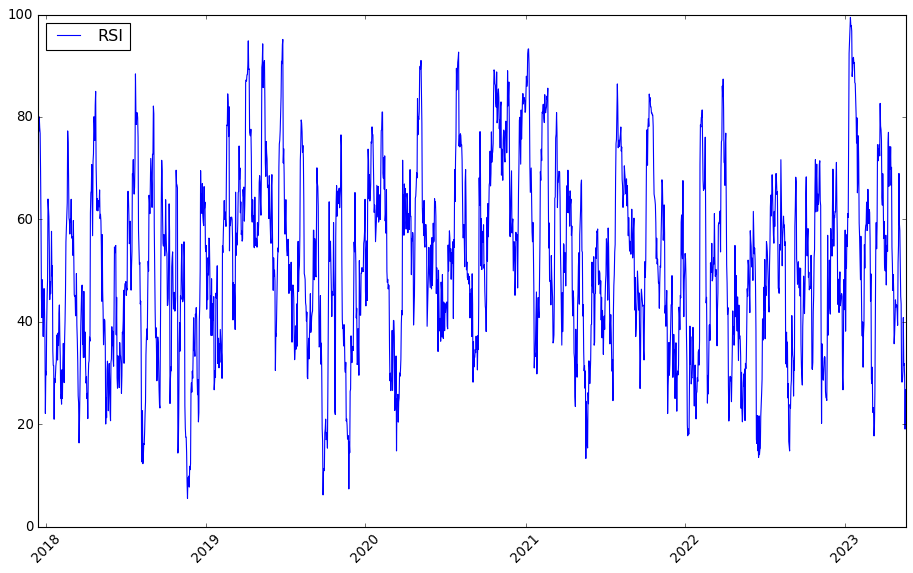

In [78]:
plt.figure(figsize=(14,8))
plt.style.use('classic')
plt.plot(rsi, label='RSI', color = 'blue')
plt.xticks(rotation=45)
plt.legend(loc='upper left')
plt.show()
columns['RSI'] = list(rsi.values)

MACD

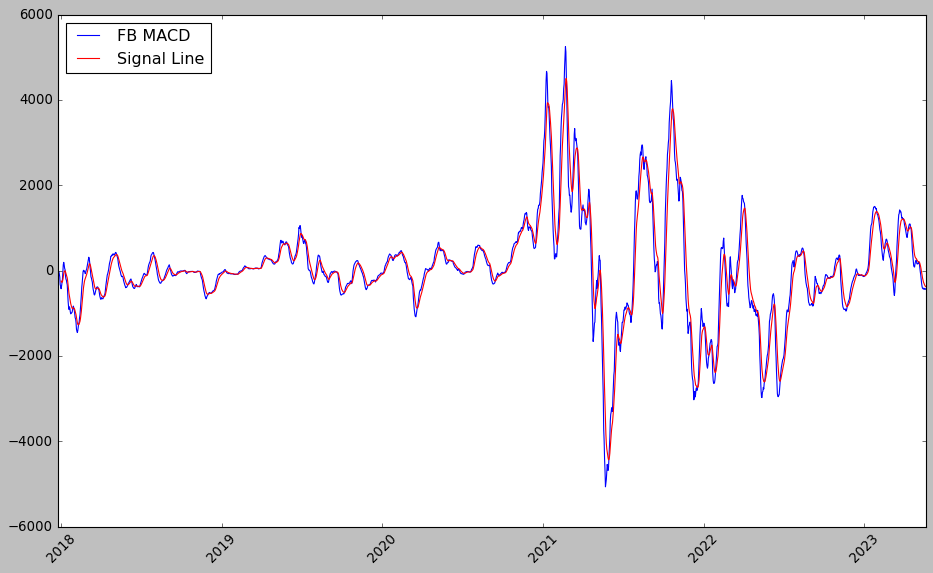

In [79]:
def calculate_macd(data, fast=12, slow=26, signal=9):
    close = data['close']
    exp1 = close.ewm(span=fast, min_periods=fast).mean()
    exp2 = close.ewm(span=slow, min_periods=slow).mean()
    macd = exp1 - exp2
    signal_line = macd.ewm(span=signal, min_periods=signal).mean()
    histogram = macd - signal_line
    return macd, signal_line, histogram

macd, signal_line, histogram = calculate_macd(OHLCV)

plt.figure(figsize=(14,8))
plt.style.use('classic')
plt.plot(OHLCV.index, macd, label='FB MACD', color = 'blue')
plt.plot(OHLCV.index, signal_line, label='Signal Line', color='red')
plt.xticks(rotation=45)
plt.legend(loc='upper left')
plt.show()

In [80]:
macd = macd.dropna()
signal_line = signal_line.dropna()
histogram = histogram.dropna()

columns['macd'] = list(macd.values)
columns['signal_line'] = list(signal_line.values)
columns['histogram'] = list(histogram.values)

close_diff low_diff open_diff high_diff

In [81]:
def difference(dataset, interval=1):
 diff = list()
 for i in range(interval, len(dataset)):
     value = dataset[i] - dataset[i - interval]
     diff.append(value)
 return diff
# df1 = df[1:]
def difference_for_every_column(df, df1): 
    for column in df.columns.values:
        diff = difference(df[column])
        df1[column+'_diff'] = diff
    return df1

In [82]:
diff_df = pd.DataFrame()
diff_df = difference_for_every_column(OHLCV[['close', 'low', 'open', 'high']] , diff_df) 
diff_df  

,close_diff,low_diff,open_diff,high_diff
0,108.90,85.07,-57.99,-728.78
1,914.71,397.16,99.03,253.74
2,51.26,1294.62,914.39,232.43
3,333.48,-137.12,51.25,675.86
4,377.70,339.38,331.48,-226.46
...,...,...,...,...
1994,367.72,-295.66,-138.43,190.42
1995,-582.50,-183.51,367.72,-18.18
1996,66.11,267.01,-582.50,-297.72
1997,229.22,178.37,66.11,-12.27


In [83]:
columns['close_diff'] = list(diff_df['close_diff'].values)
columns['low_diff'] = list(diff_df['low_diff'].values)
columns['open_diff'] = list(diff_df['open_diff'].values)
columns['high_diff'] = list(diff_df['high_diff'].values)

width_open_close, width_open_high, width_open_low

In [84]:
close_values = OHLCV['close'].values
low_values = OHLCV['low'].values
open_values = OHLCV['open'].values
high_values = OHLCV['high'].values
width_open_close = np.zeros(shape= len(OHLCV))
width_open_high = np.zeros(shape=len(OHLCV))
width_open_low = np.zeros(shape=len(OHLCV))
for i in range(len(OHLCV)):
    width_open_close[i] = close_values[i] - open_values[i] 
    width_open_high[i] = high_values[i] - open_values[i]
    width_open_low[i] = open_values[i] - low_values[i]

columns['width_open_close'] = list(width_open_close)
columns['width_open_high'] = list(width_open_high)
columns['width_open_low'] = list(width_open_low)

color_of_candle, number_candle_trend

In [85]:
color_of_candle = []
number_candle_trend = np.zeros(shape=len(OHLCV))
for i in range(len(OHLCV)):
    if width_open_close[i] > 0:
        color_of_candle.append('green')
    else:
        color_of_candle.append('red')
        
number_candle_trend[0] = 1
cnt = 1
for i in range(1,len(OHLCV)):
    if (color_of_candle[i] == color_of_candle[i - 1]):
        cnt = cnt + 1
        number_candle_trend[i] = cnt
    else:
        cnt = 1
        number_candle_trend[i] = cnt

columns['color_of_candle'] = color_of_candle
columns['number_candle_trend'] = number_candle_trend

Соберем все признаки в один датасет

In [86]:
for key, value in columns.items():
    print(key, " -> ", len(value))

close  ->  2000
SMA_200  ->  1801
EMA_200  ->  2000
SMA_50  ->  1951
EMA_50  ->  2000
RSI  ->  1986
macd  ->  1975
signal_line  ->  1967
histogram  ->  1967
close_diff  ->  1999
low_diff  ->  1999
open_diff  ->  1999
high_diff  ->  1999
width_open_close  ->  2000
width_open_high  ->  2000
width_open_low  ->  2000
color_of_candle  ->  2000
number_candle_trend  ->  2000


In [87]:
df_candles = pd.DataFrame({})
for key, value in columns.items():
    df_candles[key] = value[-(len(SMA_200)):]
    
df_candles.index = OHLCV.index[-(len(SMA_200)):]
df_candles

,close,SMA_200,EMA_200,SMA_50,EMA_50,RSI,macd,signal_line,histogram,close_diff,low_diff,open_diff,high_diff,width_open_close,width_open_high,width_open_low,color_of_candle,number_candle_trend
date,,,,,,,,,,,,,,,,,,
2018-06-16,6503.10,10237.26130,9039.788171,8083.6108,7719.694004,29.586780,-415.842237,-347.697298,-68.144939,106.39,-34.70,-246.92,-98.08,106.39,172.44,50.72,green,1.0
2018-06-17,6457.78,10220.36090,9010.121634,8025.7370,7670.191242,27.150891,-418.581200,-361.874078,-56.707122,-45.32,100.39,106.39,16.62,-45.32,82.67,56.72,red,1.0
2018-06-18,6714.82,10204.20120,8983.789810,7971.8926,7632.714110,35.931935,-395.452343,-368.589731,-26.862612,257.04,-44.97,-45.32,216.26,257.04,344.25,56.37,green,1.0
2018-06-19,6741.28,10183.60025,8958.102708,7921.7492,7597.745517,33.567210,-370.714096,-369.014604,-1.699492,26.46,270.79,256.78,37.57,26.72,125.04,42.36,green,2.0
2018-06-20,6761.27,10162.84295,8932.976618,7875.4290,7564.933186,33.260963,-345.512972,-364.314278,18.801306,19.99,-102.24,26.72,-21.70,19.99,76.62,171.32,green,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-17,27404.35,22459.81300,24844.113481,28488.4024,27707.589521,31.862199,-408.609318,-290.342031,-118.267288,367.72,-295.66,-138.43,190.42,367.72,455.50,458.66,green,1.0
2023-05-18,26821.85,22490.76900,24863.792451,28457.7220,27672.854638,29.219574,-431.257279,-318.525081,-112.732199,-582.50,-183.51,367.72,-18.18,-582.50,69.60,1009.89,red,1.0
2023-05-19,26887.96,22522.74600,24883.933422,28434.7320,27642.074456,19.047508,-438.813063,-342.582677,-96.230386,66.11,267.01,-582.50,-297.72,66.11,354.38,160.38,green,1.0


In [88]:
percent = []
for index, row in df_candles.iterrows():
    percent.append(abs(row['close_diff'])/row['close'])

change_percent_mean = np.array(percent).mean()

In [89]:
#делаем сдвиг по целевой переменной, чтобы для каждой строки целевой переменной стало значения закрытия цены на следующей свече
df_close_next = df_candles['close'][1:].values
df_candles = df_candles[:-1]
df_candles['close_next'] = df_close_next
df_candles

,close,SMA_200,EMA_200,SMA_50,EMA_50,RSI,macd,signal_line,histogram,close_diff,low_diff,open_diff,high_diff,width_open_close,width_open_high,width_open_low,color_of_candle,number_candle_trend,close_next
date,,,,,,,,,,,,,,,,,,,
2018-06-16,6503.10,10237.26130,9039.788171,8083.6108,7719.694004,29.586780,-415.842237,-347.697298,-68.144939,106.39,-34.70,-246.92,-98.08,106.39,172.44,50.72,green,1.0,6457.78
2018-06-17,6457.78,10220.36090,9010.121634,8025.7370,7670.191242,27.150891,-418.581200,-361.874078,-56.707122,-45.32,100.39,106.39,16.62,-45.32,82.67,56.72,red,1.0,6714.82
2018-06-18,6714.82,10204.20120,8983.789810,7971.8926,7632.714110,35.931935,-395.452343,-368.589731,-26.862612,257.04,-44.97,-45.32,216.26,257.04,344.25,56.37,green,1.0,6741.28
2018-06-19,6741.28,10183.60025,8958.102708,7921.7492,7597.745517,33.567210,-370.714096,-369.014604,-1.699492,26.46,270.79,256.78,37.57,26.72,125.04,42.36,green,2.0,6761.27
2018-06-20,6761.27,10162.84295,8932.976618,7875.4290,7564.933186,33.260963,-345.512972,-364.314278,18.801306,19.99,-102.24,26.72,-21.70,19.99,76.62,171.32,green,3.0,6720.64
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-16,27036.63,22426.89220,24818.382461,28485.8134,27719.966644,31.534874,-433.067967,-260.775209,-172.292758,-138.43,115.79,242.97,-366.54,-138.43,126.65,301.43,red,1.0,27404.35
2023-05-17,27404.35,22459.81300,24844.113481,28488.4024,27707.589521,31.862199,-408.609318,-290.342031,-118.267288,367.72,-295.66,-138.43,190.42,367.72,455.50,458.66,green,1.0,26821.85
2023-05-18,26821.85,22490.76900,24863.792451,28457.7220,27672.854638,29.219574,-431.257279,-318.525081,-112.732199,-582.50,-183.51,367.72,-18.18,-582.50,69.60,1009.89,red,1.0,26887.96


Кодируем категориальные переменнные

In [90]:
df_candles_supervised = df_candles.copy()

number_candle_trend_encoder = LabelEncoder()
df_candles_supervised["color_of_candle"] = number_candle_trend_encoder.fit_transform(df_candles_supervised["color_of_candle"])
color_of_candle_encoder = LabelEncoder()
df_candles_supervised["number_candle_trend"] = color_of_candle_encoder.fit_transform(df_candles_supervised["number_candle_trend"])


df_candles_supervised

,close,SMA_200,EMA_200,SMA_50,EMA_50,RSI,macd,signal_line,histogram,close_diff,low_diff,open_diff,high_diff,width_open_close,width_open_high,width_open_low,color_of_candle,number_candle_trend,close_next
date,,,,,,,,,,,,,,,,,,,
2018-06-16,6503.10,10237.26130,9039.788171,8083.6108,7719.694004,29.586780,-415.842237,-347.697298,-68.144939,106.39,-34.70,-246.92,-98.08,106.39,172.44,50.72,0,0,6457.78
2018-06-17,6457.78,10220.36090,9010.121634,8025.7370,7670.191242,27.150891,-418.581200,-361.874078,-56.707122,-45.32,100.39,106.39,16.62,-45.32,82.67,56.72,1,0,6714.82
2018-06-18,6714.82,10204.20120,8983.789810,7971.8926,7632.714110,35.931935,-395.452343,-368.589731,-26.862612,257.04,-44.97,-45.32,216.26,257.04,344.25,56.37,0,0,6741.28
2018-06-19,6741.28,10183.60025,8958.102708,7921.7492,7597.745517,33.567210,-370.714096,-369.014604,-1.699492,26.46,270.79,256.78,37.57,26.72,125.04,42.36,0,1,6761.27
2018-06-20,6761.27,10162.84295,8932.976618,7875.4290,7564.933186,33.260963,-345.512972,-364.314278,18.801306,19.99,-102.24,26.72,-21.70,19.99,76.62,171.32,0,2,6720.64
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-16,27036.63,22426.89220,24818.382461,28485.8134,27719.966644,31.534874,-433.067967,-260.775209,-172.292758,-138.43,115.79,242.97,-366.54,-138.43,126.65,301.43,1,0,27404.35
2023-05-17,27404.35,22459.81300,24844.113481,28488.4024,27707.589521,31.862199,-408.609318,-290.342031,-118.267288,367.72,-295.66,-138.43,190.42,367.72,455.50,458.66,0,0,26821.85
2023-05-18,26821.85,22490.76900,24863.792451,28457.7220,27672.854638,29.219574,-431.257279,-318.525081,-112.732199,-582.50,-183.51,367.72,-18.18,-582.50,69.60,1009.89,1,0,26887.96


# On chain 

In [91]:
# Query on-chain data

# Prepare the onchain dataframe
def prepare_onchain_data(df):
  # replace the timestamp with a data and filter some faulty values
  df['date'] = pd.to_datetime(df['time'], unit='s')
  df.index = df['date']
  df.drop(columns=['time','id','symbol', 'date'], inplace=True)
  df = df[df['hashrate'] > 0.0]
  return df
  
base_url = 'https://min-api.cryptocompare.com/data/blockchain/histo/day?fsym='
df = api_call(f'{base_url}{BTC}&limit={data_limit}')

# Filter some faulty values
onchain_df = prepare_onchain_data(df)
onchain_df

,zero_balance_addresses_all_time,unique_addresses_all_time,new_addresses,active_addresses,transaction_count,transaction_count_all_time,large_transaction_count,average_transaction_value,block_height,hashrate,difficulty,block_time,block_size,current_supply
date,,,,,,,,,,,,,,
2017-11-29,314083774,337419505,642558,1136365,398090,276268839,37662,8.194235,496764,1.161143e+07,1.347001e+12,498.244186,1064409,1.670955e+07
2017-11-30,314551084,338012487,592982,1089772,384386,276653225,32494,7.018446,496931,1.133120e+07,1.347001e+12,510.566265,1068302,1.671164e+07
2017-12-01,315049466,338621474,608987,1149321,412908,277066133,30954,5.616549,497114,1.223170e+07,1.347001e+12,472.978022,1068084,1.671393e+07
2017-12-02,315512049,339109926,488452,965635,326354,277392487,31381,6.565847,497275,1.080032e+07,1.347001e+12,535.662500,1036298,1.671594e+07
2017-12-03,315974898,339649758,539832,1032301,353044,277745531,23273,5.298105,497451,1.177726e+07,1.347001e+12,491.228571,1047375,1.671814e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-17,1104248940,1150677834,399727,838435,583454,839655047,14737,1.434237,790238,3.827953e+08,4.800553e+13,538.622642,1672989,1.937649e+07
2023-05-18,1104571843,1151064383,386549,813710,476704,840131751,15749,1.751477,790379,3.532981e+08,4.918830e+13,597.971429,1642504,1.937738e+07
2023-05-19,1104947033,1151501729,437346,898269,515474,840647225,13879,1.419288,790529,3.741912e+08,4.954970e+13,568.731544,1726897,1.937913e+07


In [92]:
pd.date_range(start = onchain_df.index[0], end = onchain_df.index[-1] ).difference(onchain_df.index)

DatetimeIndex(['2022-09-14', '2022-09-15', '2022-09-16', '2022-09-17'], dtype='datetime64[ns]', freq=None)

In [93]:
onchain_df = onchain_df.reindex(pd.date_range(start = onchain_df.index[0], end = onchain_df.index[-1] ))

In [94]:
columns = onchain_df.columns.values
for column in columns:
    onchain_df[column] = onchain_df[column].fillna(onchain_df[column].mean())

In [95]:
onchain_df = onchain_df[-len(df_candles_supervised) - 1:-1]
onchain_df

,zero_balance_addresses_all_time,unique_addresses_all_time,new_addresses,active_addresses,transaction_count,transaction_count_all_time,large_transaction_count,average_transaction_value,block_height,hashrate,difficulty,block_time,block_size,current_supply
2018-06-16,3.860796e+08,4.087123e+08,225525.0,448709.0,159090.0,322806826.0,4893.0,5.157083,527810.0,4.109009e+07,4.940705e+12,516.430303,473838.0,1.709761e+07
2018-06-17,3.862683e+08,4.089194e+08,207134.0,442321.0,144908.0,322951734.0,4707.0,4.618257,527967.0,3.919471e+07,4.940705e+12,541.403846,490980.0,1.709957e+07
2018-06-18,3.865462e+08,4.092045e+08,285090.0,581840.0,196305.0,323148039.0,7079.0,5.404680,528131.0,4.051168e+07,4.940705e+12,523.803681,648707.0,1.710162e+07
2018-06-19,3.868683e+08,4.094810e+08,276495.0,630701.0,191805.0,323339844.0,7765.0,7.678289,528286.0,3.861409e+07,5.024546e+12,558.870130,908624.0,1.710356e+07
2018-06-20,3.871478e+08,4.097698e+08,288861.0,593528.0,198889.0,323538733.0,7319.0,5.824724,528441.0,3.966299e+07,5.077499e+12,549.824675,1078000.0,1.710550e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-16,1.103901e+09,1.150278e+09,390867.0,813434.0,566462.0,839071593.0,15535.0,1.560724,790078.0,3.662720e+08,4.800553e+13,562.921053,1714052.0,1.937549e+07
2023-05-17,1.104249e+09,1.150678e+09,399727.0,838435.0,583454.0,839655047.0,14737.0,1.434237,790238.0,3.827953e+08,4.800553e+13,538.622642,1672989.0,1.937649e+07
2023-05-18,1.104572e+09,1.151064e+09,386549.0,813710.0,476704.0,840131751.0,15749.0,1.751477,790379.0,3.532981e+08,4.918830e+13,597.971429,1642504.0,1.937738e+07
2023-05-19,1.104947e+09,1.151502e+09,437346.0,898269.0,515474.0,840647225.0,13879.0,1.419288,790529.0,3.741912e+08,4.954970e+13,568.731544,1726897.0,1.937913e+07


# Balance Distribution

In [96]:
# Prepare balance distribution dataframe
def prepare_balancedistribution_data(df):
  df['balance_distribution'] = df['balance_distribution'].apply(lambda x: [i for i in x])
  json_struct = json.loads(df[['time','balance_distribution']].to_json(orient="records"))    
  df_ = pd.json_normalize(json_struct)
  df_['date'] = pd.to_datetime(df_['time'], unit='s')
  df_flat = pd.concat([df_.explode('balance_distribution').drop(['balance_distribution'], axis=1),
           df_.explode('balance_distribution')['balance_distribution'].apply(pd.Series)], axis=1)
  df_flat.reset_index(drop=True, inplace=True)
  df_flat['range'] = ['' + str(float(df_flat['from'][x])) + '_to_' + str(float(df_flat['to'][x])) for x in range(df_flat.shape[0])]
  df_flat.drop(columns=['from','to', 'time'], inplace=True)

  # Data cleansing
  df_flat = df_flat[~df_flat['range'].isin(['100000.0_to_0.0'])]
  df_flat['range'].iloc[df_flat['range'] == '1e-08_to_0.001'] = '0.0_to_0.001'
  return df_flat

# Load the balance distribution data for Bitcoin
base_url = 'https://min-api.cryptocompare.com/data/blockchain/balancedistribution/histo/day?fsym='
df_raw = api_call(f'{base_url}{BTC}&limit={data_limit}')
df_distr = prepare_balancedistribution_data(df_raw)
df_distr

,date,totalVolume,addressesCount,range
0,2017-11-29,2.349990e+03,13230707.0,0.0_to_0.001
1,2017-11-29,1.738219e+04,4335342.0,0.001_to_0.01
2,2017-11-29,1.112153e+05,3534897.0,0.01_to_0.1
3,2017-11-29,5.015338e+05,1550766.0,0.1_to_1.0
4,2017-11-29,1.423674e+06,530182.0,1.0_to_10.0
...,...,...,...,...
19984,2023-05-20,2.105882e+06,844178.0,1.0_to_10.0
19985,2023-05-20,4.442486e+06,140287.0,10.0_to_100.0
19986,2023-05-20,3.883326e+06,13826.0,100.0_to_1000.0
19987,2023-05-20,4.620023e+06,1924.0,1000.0_to_10000.0


In [97]:
df_distr.index = df_distr['date']
df_distr.drop(columns = ['date'], inplace = True)
df_distr

,totalVolume,addressesCount,range
date,,,
2017-11-29,2.349990e+03,13230707.0,0.0_to_0.001
2017-11-29,1.738219e+04,4335342.0,0.001_to_0.01
2017-11-29,1.112153e+05,3534897.0,0.01_to_0.1
2017-11-29,5.015338e+05,1550766.0,0.1_to_1.0
2017-11-29,1.423674e+06,530182.0,1.0_to_10.0
...,...,...,...
2023-05-20,2.105882e+06,844178.0,1.0_to_10.0
2023-05-20,4.442486e+06,140287.0,10.0_to_100.0
2023-05-20,3.883326e+06,13826.0,100.0_to_1000.0


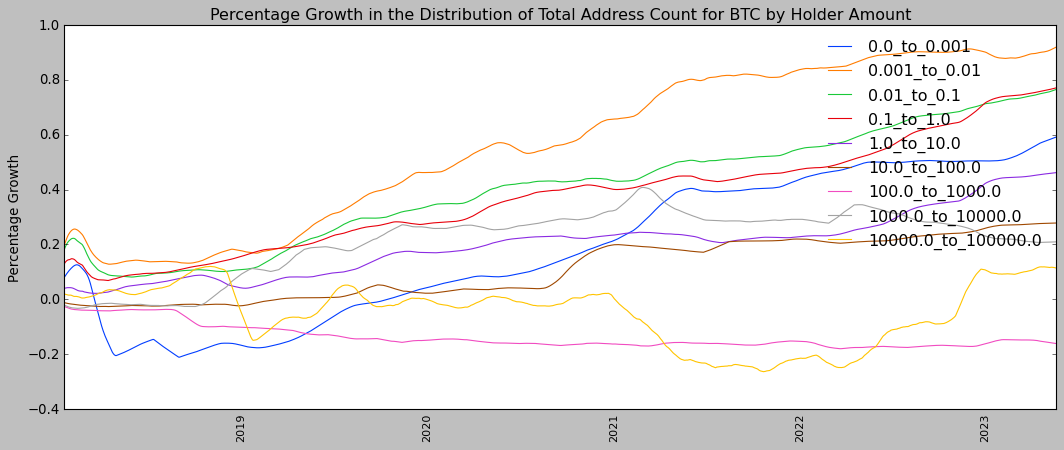

In [98]:

df_distr_add = df_distr.copy()
for i in list(df_distr_add.range.unique()):
    df_distr_add.loc[df_distr.range == i, 'addressesCount_pct_cum'] = df_distr_add[df_distr_add.range == i]['addressesCount'].pct_change().dropna().cumsum().rolling(window=50).mean()
df_distr_add.dropna(inplace=True)

fig, ax1 = plt.subplots(figsize=(16, 6))
sns.lineplot(data=df_distr_add, x='date', hue='range', linewidth = 1.0, y='addressesCount_pct_cum', ax=ax1, palette='bright')
plt.ylabel('Percentage Growth')
ax1.tick_params(axis="x", rotation=90, labelsize=10, length=0)
ax1.set(xlabel=None)
plt.title(f'Percentage Growth in the Distribution of Total Address Count for {BTC} by Holder Amount')
plt.legend(framealpha=0)
plt.show()

In [100]:
new_df_distr = pd.DataFrame({
                          'vol_0.001_to_0.01': df_distr[df_distr.range == '0.001_to_0.01']['totalVolume'].values,
                          'addresses_0.001_to_0.01': df_distr[df_distr.range == '0.001_to_0.01']['addressesCount'].values,
                          'vol_1.0_to_10.0': df_distr[df_distr.range == '1.0_to_10.0']['totalVolume'].values,
                          'addresses_1.0_to_10.0': df_distr[df_distr.range == '1.0_to_10.0']['addressesCount'].values,
                          'vol_100.0_to_1000.0': df_distr[df_distr.range == '100.0_to_1000.0']['totalVolume'].values,
                          'addresses_100.0_to_1000.0': df_distr[df_distr.range == '100.0_to_1000.0']['addressesCount'].values,
                          'vol_1000.0_to_10000.0': df_distr[df_distr.range == '1000.0_to_10000.0']['totalVolume'].values,
                          'addresses_1000.0_to_10000.0': df_distr[df_distr.range == '1000.0_to_10000.0']['addressesCount'].values,
                          'vol_10000.0_to_100000.0': df_distr[df_distr.range == '10000.0_to_100000.0']['totalVolume'].values,
                          'addresses_10000.0_to_100000.0': df_distr[df_distr.range == '10000.0_to_100000.0']['addressesCount'].values})

new_df_distr.index = OHLCV.index[:-1]
new_df_distr

,vol_0.001_to_0.01,addresses_0.001_to_0.01,vol_1.0_to_10.0,addresses_1.0_to_10.0,vol_100.0_to_1000.0,addresses_100.0_to_1000.0,vol_1000.0_to_10000.0,addresses_1000.0_to_10000.0,vol_10000.0_to_100000.0,addresses_10000.0_to_100000.0
date,,,,,,,,,,
2017-11-29,17382.185745,4335342.0,1.423674e+06,530182.0,3.825296e+06,16368.0,3.411405e+06,1570.0,2.717482e+06,109.0
2017-11-30,17583.490701,4376334.0,1.419204e+06,528331.0,3.819223e+06,16334.0,3.409920e+06,1565.0,2.738711e+06,110.0
2017-12-01,17749.696419,4406541.0,1.420801e+06,529750.0,3.804506e+06,16305.0,3.405694e+06,1568.0,2.745765e+06,111.0
2017-12-02,17802.871323,4399165.0,1.425499e+06,531547.0,3.786215e+06,16248.0,3.406775e+06,1578.0,2.755780e+06,112.0
2017-12-03,18000.933308,4429347.0,1.427554e+06,532543.0,3.786568e+06,16250.0,3.399545e+06,1574.0,2.757077e+06,112.0
...,...,...,...,...,...,...,...,...,...,...
2023-05-16,41405.040705,11145150.0,2.104756e+06,844033.0,3.885410e+06,13850.0,4.622228e+06,1921.0,2.304370e+06,110.0
2023-05-17,41493.636459,11171718.0,2.105110e+06,844024.0,3.886533e+06,13845.0,4.617977e+06,1916.0,2.308834e+06,110.0
2023-05-18,41552.824083,11201596.0,2.105753e+06,844155.0,3.882832e+06,13835.0,4.629403e+06,1923.0,2.301030e+06,109.0


In [101]:
new_df_distr = new_df_distr[-len(df_candles_supervised) - 1:-1]
new_df_distr

,vol_0.001_to_0.01,addresses_0.001_to_0.01,vol_1.0_to_10.0,addresses_1.0_to_10.0,vol_100.0_to_1000.0,addresses_100.0_to_1000.0,vol_1000.0_to_10000.0,addresses_1000.0_to_10000.0,vol_10000.0_to_100000.0,addresses_10000.0_to_100000.0
date,,,,,,,,,,
2018-06-15,20228.543698,4942051.0,1.480153e+06,561134.0,3.719454e+06,15768.0,3.408003e+06,1538.0,2.995092e+06,112.0
2018-06-16,20286.214623,4958071.0,1.478166e+06,560543.0,3.719563e+06,15763.0,3.410295e+06,1538.0,2.994761e+06,112.0
2018-06-17,20306.769695,4963043.0,1.479009e+06,560504.0,3.712628e+06,15742.0,3.402735e+06,1536.0,3.008820e+06,113.0
2018-06-18,20321.076345,4963077.0,1.481234e+06,561357.0,3.713230e+06,15743.0,3.391040e+06,1531.0,2.913957e+06,112.0
2018-06-19,20259.460025,4949655.0,1.481497e+06,561478.0,3.711817e+06,15733.0,3.386505e+06,1530.0,2.919429e+06,112.0
...,...,...,...,...,...,...,...,...,...,...
2023-05-15,41316.921454,11117678.0,2.104119e+06,843566.0,3.886272e+06,13852.0,4.625959e+06,1924.0,2.301609e+06,110.0
2023-05-16,41405.040705,11145150.0,2.104756e+06,844033.0,3.885410e+06,13850.0,4.622228e+06,1921.0,2.304370e+06,110.0
2023-05-17,41493.636459,11171718.0,2.105110e+06,844024.0,3.886533e+06,13845.0,4.617977e+06,1916.0,2.308834e+06,110.0


# Combination_df

In [102]:
combination_df = df_candles_supervised.join(onchain_df, how = 'inner')
combination_df = combination_df.join(new_df_distr, how = 'inner')
combination_df

,close,SMA_200,EMA_200,SMA_50,EMA_50,RSI,macd,signal_line,histogram,close_diff,...,vol_0.001_to_0.01,addresses_0.001_to_0.01,vol_1.0_to_10.0,addresses_1.0_to_10.0,vol_100.0_to_1000.0,addresses_100.0_to_1000.0,vol_1000.0_to_10000.0,addresses_1000.0_to_10000.0,vol_10000.0_to_100000.0,addresses_10000.0_to_100000.0
date,,,,,,,,,,,,,,,,,,,,,
2018-06-16,6503.10,10237.26130,9039.788171,8083.6108,7719.694004,29.586780,-415.842237,-347.697298,-68.144939,106.39,...,20286.214623,4958071.0,1.478166e+06,560543.0,3.719563e+06,15763.0,3.410295e+06,1538.0,2.994761e+06,112.0
2018-06-17,6457.78,10220.36090,9010.121634,8025.7370,7670.191242,27.150891,-418.581200,-361.874078,-56.707122,-45.32,...,20306.769695,4963043.0,1.479009e+06,560504.0,3.712628e+06,15742.0,3.402735e+06,1536.0,3.008820e+06,113.0
2018-06-18,6714.82,10204.20120,8983.789810,7971.8926,7632.714110,35.931935,-395.452343,-368.589731,-26.862612,257.04,...,20321.076345,4963077.0,1.481234e+06,561357.0,3.713230e+06,15743.0,3.391040e+06,1531.0,2.913957e+06,112.0
2018-06-19,6741.28,10183.60025,8958.102708,7921.7492,7597.745517,33.567210,-370.714096,-369.014604,-1.699492,26.46,...,20259.460025,4949655.0,1.481497e+06,561478.0,3.711817e+06,15733.0,3.386505e+06,1530.0,2.919429e+06,112.0
2018-06-20,6761.27,10162.84295,8932.976618,7875.4290,7564.933186,33.260963,-345.512972,-364.314278,18.801306,19.99,...,20318.285674,4960399.0,1.480621e+06,561054.0,3.714002e+06,15754.0,3.386186e+06,1527.0,2.921150e+06,112.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-15,27175.06,22394.70850,24796.088515,28487.9826,27747.857936,40.815907,-420.546345,-217.702019,-202.844326,242.97,...,41316.921454,11117678.0,2.104119e+06,843566.0,3.886272e+06,13852.0,4.625959e+06,1924.0,2.301609e+06,110.0
2023-05-16,27036.63,22426.89220,24818.382461,28485.8134,27719.966644,31.534874,-433.067967,-260.775209,-172.292758,-138.43,...,41405.040705,11145150.0,2.104756e+06,844033.0,3.885410e+06,13850.0,4.622228e+06,1921.0,2.304370e+06,110.0
2023-05-17,27404.35,22459.81300,24844.113481,28488.4024,27707.589521,31.862199,-408.609318,-290.342031,-118.267288,367.72,...,41493.636459,11171718.0,2.105110e+06,844024.0,3.886533e+06,13845.0,4.617977e+06,1916.0,2.308834e+06,110.0


In [103]:
combination_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1799 entries, 2018-06-16 to 2023-05-19
Data columns (total 43 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   close                            1799 non-null   float64
 1   SMA_200                          1799 non-null   float64
 2   EMA_200                          1799 non-null   float64
 3   SMA_50                           1799 non-null   float64
 4   EMA_50                           1799 non-null   float64
 5   RSI                              1799 non-null   float64
 6   macd                             1799 non-null   float64
 7   signal_line                      1799 non-null   float64
 8   histogram                        1799 non-null   float64
 9   close_diff                       1799 non-null   float64
 10  low_diff                         1799 non-null   float64
 11  open_diff                        1799 non-null   float64
 12  hi

In [104]:
cols = list(combination_df.columns)
a, b = cols.index('close_next'), cols.index('addresses_10000.0_to_100000.0')
cols[b], cols[a] = cols[a], cols[b]
combination_df = combination_df[cols]
combination_df

,close,SMA_200,EMA_200,SMA_50,EMA_50,RSI,macd,signal_line,histogram,close_diff,...,vol_0.001_to_0.01,addresses_0.001_to_0.01,vol_1.0_to_10.0,addresses_1.0_to_10.0,vol_100.0_to_1000.0,addresses_100.0_to_1000.0,vol_1000.0_to_10000.0,addresses_1000.0_to_10000.0,vol_10000.0_to_100000.0,close_next
date,,,,,,,,,,,,,,,,,,,,,
2018-06-16,6503.10,10237.26130,9039.788171,8083.6108,7719.694004,29.586780,-415.842237,-347.697298,-68.144939,106.39,...,20286.214623,4958071.0,1.478166e+06,560543.0,3.719563e+06,15763.0,3.410295e+06,1538.0,2.994761e+06,6457.78
2018-06-17,6457.78,10220.36090,9010.121634,8025.7370,7670.191242,27.150891,-418.581200,-361.874078,-56.707122,-45.32,...,20306.769695,4963043.0,1.479009e+06,560504.0,3.712628e+06,15742.0,3.402735e+06,1536.0,3.008820e+06,6714.82
2018-06-18,6714.82,10204.20120,8983.789810,7971.8926,7632.714110,35.931935,-395.452343,-368.589731,-26.862612,257.04,...,20321.076345,4963077.0,1.481234e+06,561357.0,3.713230e+06,15743.0,3.391040e+06,1531.0,2.913957e+06,6741.28
2018-06-19,6741.28,10183.60025,8958.102708,7921.7492,7597.745517,33.567210,-370.714096,-369.014604,-1.699492,26.46,...,20259.460025,4949655.0,1.481497e+06,561478.0,3.711817e+06,15733.0,3.386505e+06,1530.0,2.919429e+06,6761.27
2018-06-20,6761.27,10162.84295,8932.976618,7875.4290,7564.933186,33.260963,-345.512972,-364.314278,18.801306,19.99,...,20318.285674,4960399.0,1.480621e+06,561054.0,3.714002e+06,15754.0,3.386186e+06,1527.0,2.921150e+06,6720.64
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-15,27175.06,22394.70850,24796.088515,28487.9826,27747.857936,40.815907,-420.546345,-217.702019,-202.844326,242.97,...,41316.921454,11117678.0,2.104119e+06,843566.0,3.886272e+06,13852.0,4.625959e+06,1924.0,2.301609e+06,27036.63
2023-05-16,27036.63,22426.89220,24818.382461,28485.8134,27719.966644,31.534874,-433.067967,-260.775209,-172.292758,-138.43,...,41405.040705,11145150.0,2.104756e+06,844033.0,3.885410e+06,13850.0,4.622228e+06,1921.0,2.304370e+06,27404.35
2023-05-17,27404.35,22459.81300,24844.113481,28488.4024,27707.589521,31.862199,-408.609318,-290.342031,-118.267288,367.72,...,41493.636459,11171718.0,2.105110e+06,844024.0,3.886533e+06,13845.0,4.617977e+06,1916.0,2.308834e+06,26821.85


In [105]:
combination_df.to_csv('combination_df', sep=';')

# Feature Selection

Определим наилучший метод для отбора признаков

Функция разбиения датасета и нормализации

In [106]:
def split_normalization_for_VIF_RFE_PCA(dataset):
    split = 0.7
    split_val = 0.8
    i_split = int(len(dataset) * split)
    train = dataset[:i_split]
    test = dataset[i_split:]
    i_split_val = int(len(train) * split_val)
    val = train[i_split_val:]
    train = train[:i_split_val]

    features = dataset.drop(['color_of_candle', 'number_candle_trend'], axis =1).columns.values
    # train

    train_norm = train.loc[:, features].values
    train_norm = scaler.fit_transform(train_norm)
    train_norm = pd.DataFrame(train_norm, columns=features)

    train_categorial = train.loc[:,['color_of_candle', 'number_candle_trend']].reset_index()
    train_std = pd.concat([train_norm, train_categorial], axis=1)
    
    # test

    test_norm = test.loc[:, features].values
    test_norm = scaler.transform(test_norm)
    test_norm = pd.DataFrame(test_norm, columns=features)
    

    test_categorial = test.loc[:,['color_of_candle', 'number_candle_trend']].reset_index()
    test_std = pd.concat([test_norm, test_categorial], axis=1)
    
    # val
    val_norm = val.loc[:, features].values
    val_norm = scaler.transform(val_norm)
    val_norm = pd.DataFrame(val_norm, columns=features)

    val_categorial = val.loc[:,['color_of_candle', 'number_candle_trend']].reset_index()
    val_std = pd.concat([val_norm, val_categorial], axis=1)



    train_X = train_std.drop(['close_next'],axis=1)
    train_X.index = train_X['date']
    train_X = train_X.drop(['date'],axis=1)
    train_y = train_std['close_next']
    
    test_X = test_std.drop(['close_next'],axis=1)
    test_X.index = test_X['date']
    test_X = test_X.drop(['date'],axis=1)
    test_y = test_std['close_next']


    val_X = val_std.drop(['close_next'],axis=1)
    val_X.index = val_X['date']
    val_X = val_X.drop(['date'],axis=1)
    val_y = val_std['close_next']

    return train_X, train_y, test_X, test_y, val_X, val_y

Функция создания последовательностей

In [107]:
# multivariate output data prep
from numpy import array
from numpy import hstack

# split a multivariate sequence into samples
def split_sequences(df, n_steps):

    columns = df.columns.values

    arrays = []
    for column in columns:
        values = df[column].values
        a = values.reshape(len(values), 1)
        arrays.append(a)

    sequences = hstack((arrays))

    X, y = list(), list()
    for i in range(len(sequences)):

        end_ix = i + n_steps

        if end_ix > len(sequences)-1:
            break

        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return array(X)

Метрики

In [108]:
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

def smape(A, F):
    return 1/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))


def count_money(real, forecast):
    profit = 0
    for i in range(1, len(real)):
        if ((forecast[i] > real[i-1]) & (real[i] > real[i-1])) | ((forecast[i] < real[i-1]) & (real[i] < real[i-1])):
            profit = profit + abs(real[i] - real[i-1])
        else:
            profit = profit - abs(real[i] - real[i-1])
    return profit

def count_money_2(real, forecast):
    profit = 0
    for i in range(1, len(real)):
        if ((forecast[i] > real[i-1]) & (real[i] > real[i-1])):
            if (forecast[i] > real[i]):
                profit = profit + abs(real[i] - real[i-1])
            else:
                profit = profit + abs(forecast[i] - real[i-1])
        elif ((forecast[i] < real[i-1]) & (real[i] < real[i-1])):
            if (forecast[i] < real[i]):
                profit = profit + abs(real[i] - real[i-1])
            else:
                profit = profit + abs(forecast[i] - real[i-1])
        else:
            profit = profit - abs(real[i] - real[i-1])
    return profit



def direction(real, forecast):
    directions = []
    for i in range(1, len(real)):
        if ((real[i] > real[i - 1]) & (forecast[i] > real[i - 1])) | ((real[i] < real[i - 1]) & (forecast[i] < real[i - 1])):
                directions.append(1)
        else:
            directions.append(0)
    return sum(directions)/len(directions)


def success_prediction(real, forecast, diff = change_percent_mean, type_of_diff = 'percent'):
    success_prediction = []
    if (type_of_diff == 'absolute'):
        for i in range(1, len(real)):
            if ((((real[i] > real[i - 1]) & (forecast[i] > real[i - 1])) | ((real[i] < real[i - 1]) & (forecast[i] < real[i - 1]))) 
               & (abs(forecast[i] - real[i]) < diff)):
                    success_prediction.append(1)
            else:
                success_prediction.append(0)
    else: 
        diff = round(diff, 2)
        for i in range(1, len(real)):
            if ((((real[i] > real[i - 1]) & (forecast[i] > real[i - 1])) | ((real[i] < real[i - 1]) & (forecast[i] < real[i - 1]))) 
               & (abs(forecast[i] - real[i]) / real[i] < diff)):
                    success_prediction.append(1)
            else:
                success_prediction.append(0)
    return sum(success_prediction)/len(success_prediction)

def success_prediction_with_change_price(real, forecast, change_price = 5, diff = 250, type_of_diff = 'percent'):
    change_price = round(change_price/100, 2)
    success_prediction_with_change_price = []
    if (type_of_diff == 'absolute'):
        for i in range(1, len(real)):
            if (abs(real[i] - real[i-1]) / real[i-1] < change_price):
                if ((((real[i] > real[i - 1]) & (forecast[i] > real[i - 1])) | ((real[i] < real[i - 1]) & (forecast[i] < real[i - 1]))) 
                   & (abs(forecast[i] - real[i]) < diff)):
                        success_prediction_with_change_price.append(1)
                else:
                    success_prediction_with_change_price.append(0)
    else: 
        diff = round(diff/100, 2)
        for i in range(1, len(real)):
            if (abs(real[i] - real[i-1]) / real[i-1] < change_price):
                if ((((real[i] > real[i - 1]) & (forecast[i] > real[i - 1])) | ((real[i] < real[i - 1]) & (forecast[i] < real[i - 1]))) 
                   & (abs(forecast[i] - real[i]) / real[i] < diff)):
                        success_prediction_with_change_price.append(1)
                else:
                    success_prediction_with_change_price.append(0)
    return sum(success_prediction_with_change_price)/len(success_prediction_with_change_price)




def metrics(real, forecast):
    
    if type(real)==pd.core.frame.DataFrame:
        real=real[real.columns[0]].values
    
    print("Тест на стационарность:")
    dftest = adfuller(real-forecast, autolag='AIC')
    print("\tT-статистика = {:.3f}".format(dftest[0]))
    print("\tP-значение = {:.3f}".format(dftest[1]))
    print("Критические значения :")
    for k, v in dftest[4].items():
        print("\t{}: {} - Данные {} стационарны с вероятностью {}% процентов".format(k, v, "не" if v<dftest[0] else "", 100-int(k[:-1])))
    
    #real=np.array(real[real.columns[0]].values)
    forecast=np.array(forecast)
    print('MAD:', round(abs(real-forecast).mean(),4))
    print('MSE:', round(((real-forecast)**2).mean(),4))
    print('MAPE:', round((abs(real-forecast)/real).mean(),4))
    print('MPE:', round(((real-forecast)/real).mean(),4))
    print('Стандартная ошибка:', round(((real-forecast)**2).mean()**0.5,4)) 
    print('Среднее угадывание направления: ', direction(real, forecast))
    # print('Процент удачных предсказаний: ', success_prediction(real, forecast))
    # print('Процент удачных предсказаний c разницей между соседними ценами в 2: ', success_prediction_with_change_price(real, forecast))
    print('R2:', round(r2_score(real, forecast),20))
    print('SMAPE:', round(np.sqrt(smape(real, forecast)),20))
    print('Прибыль, при условии закрытия сделки по каждой свечи:', round(count_money(real, forecast), 20))
    print('Прибыль, при условии закрытия сделки по каждой свечи (способ 2):', round(count_money_2(real, forecast), 20))
    
    plt.plot(real-forecast)
    

    
    
def metrics_short(real, forecast):
    real=np.array(real[real.columns[0]].values)
    forecast=np.array(forecast)
    print('MAD:', round(abs(real-forecast).mean(),4))
    print('MSE:', round(((real-forecast)**2).mean(),4))
    print('MAPE:', round((abs(real-forecast)/real).mean(),4))
    print('MPE:', round(((real-forecast)/real).mean(),4))
    print('Стандартная ошибка:', round(((real-forecast)**2).mean()**0.5,4)) 
    print('R2:', round(r2_score(real, forecast),20))
    print('SMAPE:', round(np.sqrt(smape(real, forecast)),20))

VIF

In [109]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
def vif_creation(X):
    vif_df = pd.DataFrame()
    vif_df['Feature Name'] = X.columns
    vif_df['Vif Factor'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_df

vif_df = combination_df.drop(['close_next'], axis =1)
vif_df = vif_creation(vif_df)
vif_df

,Feature Name,Vif Factor
0,close,1.624384e+03
1,SMA_200,5.772494e+02
2,EMA_200,1.847625e+03
3,SMA_50,2.373441e+03
4,EMA_50,7.713387e+03
5,RSI,2.409519e+00
6,macd,5.996804e+11
7,signal_line,2.971692e+12
8,histogram,2.930028e+11
9,close_diff,2.757319e+07


Выберем признаки со значением меньше 6

In [110]:
columns_vif = ['close']
for index, row in vif_df.iterrows():
    if (row['Vif Factor'] < 6):
      columns_vif.append(row['Feature Name'])

columns_vif.append('close_next')


df_candles_VIF = combination_df[columns_vif]

df_candles_VIF

,close,RSI,low_diff,open_diff,high_diff,color_of_candle,number_candle_trend,transaction_count,average_transaction_value,block_time,block_size,close_next
date,,,,,,,,,,,,
2018-06-16,6503.10,29.586780,-34.70,-246.92,-98.08,0,0,159090.0,5.157083,516.430303,473838.0,6457.78
2018-06-17,6457.78,27.150891,100.39,106.39,16.62,1,0,144908.0,4.618257,541.403846,490980.0,6714.82
2018-06-18,6714.82,35.931935,-44.97,-45.32,216.26,0,0,196305.0,5.404680,523.803681,648707.0,6741.28
2018-06-19,6741.28,33.567210,270.79,256.78,37.57,0,1,191805.0,7.678289,558.870130,908624.0,6761.27
2018-06-20,6761.27,33.260963,-102.24,26.72,-21.70,0,2,198889.0,5.824724,549.824675,1078000.0,6720.64
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-15,27175.06,40.815907,146.35,142.54,466.77,0,1,526379.0,1.365127,580.041096,1751037.0,27036.63
2023-05-16,27036.63,31.534874,115.79,242.97,-366.54,1,0,566462.0,1.560724,562.921053,1714052.0,27404.35
2023-05-17,27404.35,31.862199,-295.66,-138.43,190.42,0,0,583454.0,1.434237,538.622642,1672989.0,26821.85


               close       RSI  low_diff  open_diff  high_diff  \
date                                                             
2018-06-16 -0.459225 -1.324559 -0.123260  -0.440322  -0.235340   
2018-06-17 -0.463627 -1.455913  0.072660   0.080289  -0.056716   
2018-06-18 -0.438662 -0.982400 -0.138154  -0.143259   0.254186   
2018-06-19 -0.436092 -1.109916  0.319790   0.301893  -0.024091   
2018-06-20 -0.434151 -1.126430 -0.221212  -0.037106  -0.116392   
...              ...       ...       ...        ...        ...   
2021-03-14  4.639459  1.226988  4.100471   5.705002  -0.198603   
2021-03-15  4.315654  0.440044 -6.052883  -3.290091  -1.773047   
2021-03-16  4.438032  0.698831 -2.376797  -4.989037  -5.771667   
2021-03-17  4.630728  0.705481  1.213446   1.780163   3.093137   
2021-03-18  4.507798  0.821017  4.083735   2.846981   1.634355   

            transaction_count  average_transaction_value  block_time  \
date                                                                 

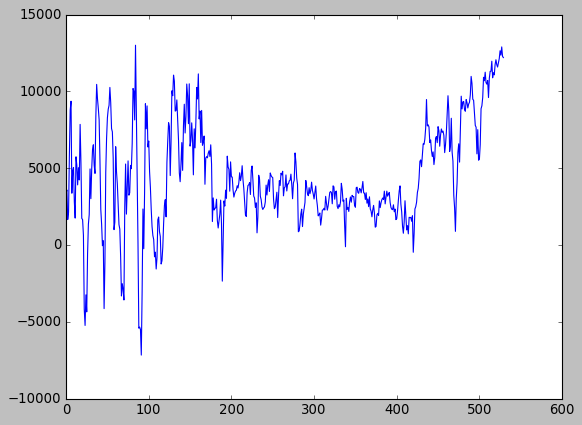

In [111]:
scaler = StandardScaler()

train_X, train_y, test_X, test_y, val_X, val_y = split_normalization_for_VIF_RFE_PCA(df_candles_VIF)


print(train_X)
n_steps = 10
Train_X_sq = split_sequences(train_X, n_steps)
Test_X_sq = split_sequences(test_X, n_steps)
Val_X_sq = split_sequences(val_X, n_steps)


train_y_sq = train_y[n_steps - 1: -1]
val_y_sq = val_y[n_steps - 1: -1]
test_y_sq = test_y[n_steps - 1: -1]

# design network
model = Sequential()
model.add(LSTM(256, input_shape=(Train_X_sq.shape[1], Train_X_sq.shape[2]), activation = 'elu',return_sequences=True))
model.add(LSTM(128, activation = 'elu',return_sequences=True))
model.add(LSTM(56, activation = 'elu'))
model.add(Dense(1))
model.compile(loss='mse', optimizer='rmsprop', metrics=["mean_absolute_error"])
# fit network

callback = tf.keras.callbacks.EarlyStopping(monitor='val_mean_absolute_error', patience=3)
model.fit(Train_X_sq, train_y_sq, batch_size=1, epochs=20, validation_data=(Val_X_sq, val_y_sq), callbacks = [callback])

yhat = model.predict(Test_X_sq)

mean = scaler.mean_
mean = mean[len(mean) - 1]
scale = scaler.scale_
scale = scale[len(scale) - 1]
inv_yhat_VIF = yhat.reshape(yhat.shape[0])
inv_y_VIF = test_y_sq.values
for i in range(len(inv_yhat_VIF)):
    inv_yhat_VIF[i] = inv_yhat_VIF[i] * scale + mean
    inv_y_VIF [i] = inv_y_VIF [i] * scale + mean

metrics(inv_y_VIF, inv_yhat_VIF)


RFE

In [112]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

scaler = StandardScaler()

train_X, train_y, test_X, test_y, val_X, val_y = split_normalization_for_VIF_RFE_PCA(combination_df)


Train_yhat_metrics_RFE={}
Train_yhat_metrics_RFE['RMSE'] = []
Train_yhat_metrics_RFE['MAPE'] = []
Train_yhat_metrics_RFE['SMAPE'] = []
Train_yhat_metrics_RFE['R2'] = []
Train_yhat_metrics_RFE['direction'] = []
Train_yhat_metrics_RFE['profit'] = []

Test_yhat_metrics_RFE={}
Test_yhat_metrics_RFE['RMSE'] = []
Test_yhat_metrics_RFE['MAPE'] = []
Test_yhat_metrics_RFE['SMAPE'] = []
Test_yhat_metrics_RFE['R2'] = []
Test_yhat_metrics_RFE['direction'] = []
Test_yhat_metrics_RFE['profit'] = []
 
m=train_X.shape[1]-1

features_rfe = []

for i in range(m):

    train_y_1 = train_y.copy()
    
    rfe = RFE(LinearRegression(),n_features_to_select=train_X.shape[1]-i)            
    rfe = rfe.fit(train_X, train_y_1)
    
    Train_X_std_rfe = train_X.loc[:,rfe.support_]
    Test_X_std_rfe = test_X.loc[:,rfe.support_]
    Val_X_std_rfe = val_X.loc[:,rfe.support_]
    
    features_rfe.append(rfe.support_)
    
    n_steps = 10
    Train_X_std_rfe = split_sequences(Train_X_std_rfe, n_steps)
    Test_X_std_rfe = split_sequences(Test_X_std_rfe, n_steps)
    Val_X_std_rfe = split_sequences(Val_X_std_rfe, n_steps)


    train_y_rfe = train_y[n_steps - 1: -1]
    val_y_rfe = val_y[n_steps - 1: -1]
    test_y_rfe = test_y[n_steps - 1: -1]
    
    # design network
    model = Sequential()
    model.add(LSTM(256, input_shape=(Train_X_std_rfe.shape[1], Train_X_std_rfe.shape[2]), activation = 'elu',return_sequences=True))
    model.add(LSTM(128, activation = 'elu',return_sequences=True))
    model.add(LSTM(56, activation = 'elu'))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='rmsprop', metrics=["mean_absolute_error"])
    # fit network
    
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_mean_absolute_error', patience=3)
    model.fit(Train_X_std_rfe, train_y_rfe, batch_size=1, epochs=20, validation_data=(Val_X_std_rfe, val_y_rfe), callbacks = [callback])
    # plot history

    yhat_train = model.predict(Train_X_std_rfe)
    yhat_test = model.predict(Test_X_std_rfe)
   
    mean = scaler.mean_
    mean = mean[len(mean) - 1]
    scale = scaler.scale_
    scale = scale[len(scale) - 1]
   
    inv_yhat_train_RFE = yhat_train.reshape(yhat_train.shape[0])
    inv_y_train_RFE = train_y_rfe.copy().values
    
    for i in range(len(inv_yhat_train_RFE)):
        inv_yhat_train_RFE[i] = inv_yhat_train_RFE[i] * scale + mean
        inv_y_train_RFE[i] = inv_y_train_RFE [i] * scale + mean
    
   
    inv_yhat_test_RFE = yhat_test.reshape(yhat_test.shape[0])
    inv_y_test_RFE = test_y_rfe.copy().values
    for i in range(len(inv_yhat_test_RFE)):
        inv_yhat_test_RFE[i] = inv_yhat_test_RFE[i] * scale + mean
        inv_y_test_RFE[i] = inv_y_test_RFE [i] * scale + mean

    Train_yhat_metrics_RFE['RMSE'].append(np.sqrt(mean_squared_error(inv_y_train_RFE, inv_yhat_train_RFE)))
    Train_yhat_metrics_RFE['MAPE'].append(round((abs(inv_y_train_RFE-inv_yhat_train_RFE)/inv_y_train_RFE).mean(),4))
    Train_yhat_metrics_RFE['SMAPE'].append(round(np.sqrt(smape(inv_y_train_RFE, inv_yhat_train_RFE)),20))
    Train_yhat_metrics_RFE['R2'].append(round(r2_score(inv_y_train_RFE, inv_yhat_train_RFE),20))
    Train_yhat_metrics_RFE['direction'].append(round(direction(inv_y_train_RFE, inv_yhat_train_RFE),4))
    Train_yhat_metrics_RFE['profit'].append(round(count_money(inv_y_train_RFE, inv_yhat_train_RFE), 20))

    Test_yhat_metrics_RFE['RMSE'].append(np.sqrt(mean_squared_error(inv_y_test_RFE, inv_yhat_test_RFE)))
    Test_yhat_metrics_RFE['MAPE'].append(round((abs(inv_y_test_RFE-inv_yhat_test_RFE)/inv_y_test_RFE).mean(),4))
    Test_yhat_metrics_RFE['SMAPE'].append(round(np.sqrt(smape(inv_y_test_RFE, inv_yhat_test_RFE)),20))
    Test_yhat_metrics_RFE['R2'].append(round(r2_score(inv_y_test_RFE, inv_yhat_test_RFE),20))
    Test_yhat_metrics_RFE['direction'].append(round(direction(inv_y_test_RFE, inv_yhat_test_RFE),4))
    Test_yhat_metrics_RFE['profit'].append(round(count_money(inv_y_test_RFE, inv_yhat_test_RFE), 20))

    
    


Epoch 1/20
997/997 [==============================] - 35s 31ms/step - loss: 0.7480 - mean_absolute_error: 0.2343 - val_loss: 3.0735 - val_mean_absolute_error: 1.4519
Epoch 2/20
997/997 [==============================] - 31s 31ms/step - loss: 0.0848 - mean_absolute_error: 0.1335 - val_loss: 0.8889 - val_mean_absolute_error: 0.7918
Epoch 3/20
997/997 [==============================] - 31s 31ms/step - loss: 0.0507 - mean_absolute_error: 0.1008 - val_loss: 7.3651 - val_mean_absolute_error: 2.6647
Epoch 4/20
997/997 [==============================] - 31s 31ms/step - loss: 0.0320 - mean_absolute_error: 0.0867 - val_loss: 1.5026 - val_mean_absolute_error: 1.0314
Epoch 5/20
17/17 [==============================] - 1s 37ms/step
0      -0.463913
1      -0.439197
2      -0.436653
3      -0.434731
4      -0.438638
          ...   
1002    4.267564
1003    4.388718
1004    4.579487
1005    4.457786
1006    4.497872
Name: close_next, Length: 1007, dtype: float64
Epoch 1/20
997/997 [=================

Epoch 2/20
997/997 [==============================] - 26s 26ms/step - loss: 0.0615 - mean_absolute_error: 0.1115 - val_loss: 7.0925 - val_mean_absolute_error: 2.6122
Epoch 3/20
997/997 [==============================] - 26s 26ms/step - loss: 0.0514 - mean_absolute_error: 0.0927 - val_loss: 0.9237 - val_mean_absolute_error: 0.7924
Epoch 4/20
17/17 [==============================] - 1s 33ms/step
0      -0.463913
1      -0.439197
2      -0.436653
3      -0.434731
4      -0.438638
          ...   
1002    4.267564
1003    4.388718
1004    4.579487
1005    4.457786
1006    4.497872
Name: close_next, Length: 1007, dtype: float64
Epoch 1/20
997/997 [==============================] - 30s 27ms/step - loss: 0.5934 - mean_absolute_error: 0.2158 - val_loss: 0.8404 - val_mean_absolute_error: 0.7804
Epoch 2/20
997/997 [==============================] - 26s 26ms/step - loss: 0.0786 - mean_absolute_error: 0.1254 - val_loss: 0.9018 - val_mean_absolute_error: 0.7864
Epoch 3/20
997/997 [=================

Epoch 1/20
997/997 [==============================] - 29s 26ms/step - loss: 0.5272 - mean_absolute_error: 0.2108 - val_loss: 1.5642 - val_mean_absolute_error: 1.0447
Epoch 2/20
997/997 [==============================] - 26s 26ms/step - loss: 0.0510 - mean_absolute_error: 0.1137 - val_loss: 4.6307 - val_mean_absolute_error: 1.9866
Epoch 3/20
997/997 [==============================] - 26s 26ms/step - loss: 0.0298 - mean_absolute_error: 0.0868 - val_loss: 3.0472 - val_mean_absolute_error: 1.5589
Epoch 4/20
997/997 [==============================] - 26s 26ms/step - loss: 0.0279 - mean_absolute_error: 0.0794 - val_loss: 1.1269 - val_mean_absolute_error: 0.8870
Epoch 5/20
997/997 [==============================] - 26s 26ms/step - loss: 0.0260 - mean_absolute_error: 0.0776 - val_loss: 5.1848 - val_mean_absolute_error: 2.1650
Epoch 6/20
997/997 [==============================] - 26s 26ms/step - loss: 0.0189 - mean_absolute_error: 0.0667 - val_loss: 9.9318 - val_mean_absolute_error: 3.0624
Epoc

Epoch 1/20
997/997 [==============================] - 28s 25ms/step - loss: 0.2477 - mean_absolute_error: 0.1929 - val_loss: 1.3540 - val_mean_absolute_error: 0.9846
Epoch 2/20
997/997 [==============================] - 25s 25ms/step - loss: 0.0591 - mean_absolute_error: 0.1233 - val_loss: 1.0023 - val_mean_absolute_error: 0.8721
Epoch 3/20
997/997 [==============================] - 25s 25ms/step - loss: 0.0364 - mean_absolute_error: 0.0989 - val_loss: 1.7057 - val_mean_absolute_error: 1.1090
Epoch 4/20
997/997 [==============================] - 25s 25ms/step - loss: 0.0269 - mean_absolute_error: 0.0862 - val_loss: 1.6229 - val_mean_absolute_error: 1.0331
Epoch 5/20
17/17 [==============================] - 1s 32ms/step
0      -0.463913
1      -0.439197
2      -0.436653
3      -0.434731
4      -0.438638
          ...   
1002    4.267564
1003    4.388718
1004    4.579487
1005    4.457786
1006    4.497872
Name: close_next, Length: 1007, dtype: float64
Epoch 1/20
997/997 [=================

17/17 [==============================] - 1s 34ms/step
0      -0.463913
1      -0.439197
2      -0.436653
3      -0.434731
4      -0.438638
          ...   
1002    4.267564
1003    4.388718
1004    4.579487
1005    4.457786
1006    4.497872
Name: close_next, Length: 1007, dtype: float64
Epoch 1/20
997/997 [==============================] - 29s 26ms/step - loss: 0.4278 - mean_absolute_error: 0.2133 - val_loss: 0.7865 - val_mean_absolute_error: 0.7591
Epoch 2/20
997/997 [==============================] - 25s 25ms/step - loss: 0.0555 - mean_absolute_error: 0.1190 - val_loss: 1.4292 - val_mean_absolute_error: 0.9643
Epoch 3/20
997/997 [==============================] - 25s 25ms/step - loss: 0.0354 - mean_absolute_error: 0.0971 - val_loss: 2.1108 - val_mean_absolute_error: 1.2803
Epoch 4/20
17/17 [==============================] - 1s 33ms/step
0      -0.463913
1      -0.439197
2      -0.436653
3      -0.434731
4      -0.438638
          ...   
1002    4.267564
1003    4.388718
1004    4.579

17/17 [==============================] - 1s 31ms/step
0      -0.463913
1      -0.439197
2      -0.436653
3      -0.434731
4      -0.438638
          ...   
1002    4.267564
1003    4.388718
1004    4.579487
1005    4.457786
1006    4.497872
Name: close_next, Length: 1007, dtype: float64
Epoch 1/20
997/997 [==============================] - 28s 25ms/step - loss: 0.4174 - mean_absolute_error: 0.2073 - val_loss: 0.2480 - val_mean_absolute_error: 0.3788
Epoch 2/20
997/997 [==============================] - 24s 24ms/step - loss: 0.0593 - mean_absolute_error: 0.1233 - val_loss: 0.2163 - val_mean_absolute_error: 0.4011
Epoch 3/20
997/997 [==============================] - 24s 24ms/step - loss: 0.0445 - mean_absolute_error: 0.1049 - val_loss: 0.2689 - val_mean_absolute_error: 0.3963
Epoch 4/20
17/17 [==============================] - 1s 31ms/step
0      -0.463913
1      -0.439197
2      -0.436653
3      -0.434731
4      -0.438638
          ...   
1002    4.267564
1003    4.388718
1004    4.579

Epoch 8/20
997/997 [==============================] - 44s 44ms/step - loss: 0.0174 - mean_absolute_error: 0.0630 - val_loss: 0.8998 - val_mean_absolute_error: 0.8624
Epoch 9/20
17/17 [==============================] - 1s 69ms/step
0      -0.463913
1      -0.439197
2      -0.436653
3      -0.434731
4      -0.438638
          ...   
1002    4.267564
1003    4.388718
1004    4.579487
1005    4.457786
1006    4.497872
Name: close_next, Length: 1007, dtype: float64
Epoch 1/20
997/997 [==============================] - 49s 37ms/step - loss: 0.1120 - mean_absolute_error: 0.1552 - val_loss: 1.3336 - val_mean_absolute_error: 0.9350
Epoch 2/20
997/997 [==============================] - 43s 43ms/step - loss: 0.0450 - mean_absolute_error: 0.1024 - val_loss: 0.4647 - val_mean_absolute_error: 0.5407
Epoch 3/20
997/997 [==============================] - 45s 45ms/step - loss: 0.0328 - mean_absolute_error: 0.0900 - val_loss: 0.2216 - val_mean_absolute_error: 0.3725
Epoch 4/20
997/997 [=================

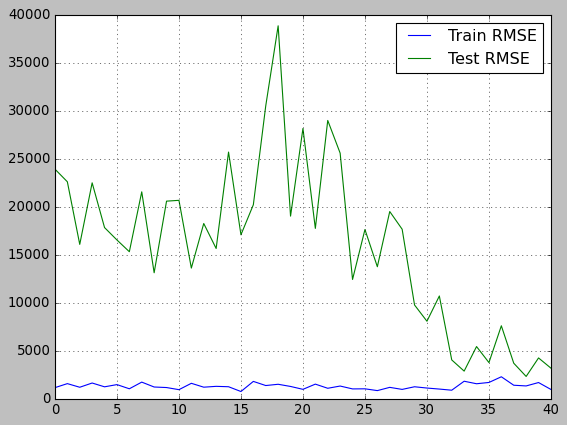

In [113]:
plt.plot(Train_yhat_metrics_RFE['RMSE'], label='Train RMSE')
plt.plot(Test_yhat_metrics_RFE['RMSE'], label='Test RMSE')
plt.legend()
plt.grid()
plt.show()

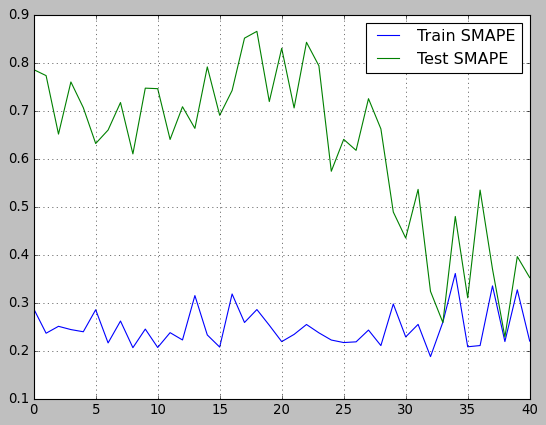

In [114]:
plt.plot(Train_yhat_metrics_RFE['SMAPE'], label='Train SMAPE')
plt.plot(Test_yhat_metrics_RFE['SMAPE'], label='Test SMAPE')
plt.legend()
plt.grid()
plt.show()

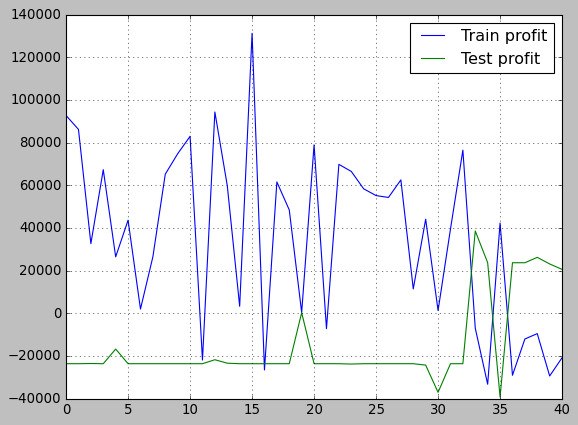

In [115]:
plt.plot(Train_yhat_metrics_RFE['profit'], label='Train profit')
plt.plot(Test_yhat_metrics_RFE['profit'], label='Test profit')
plt.legend()
plt.grid()
plt.show()

::Сравнив все показатели самым лучшим показателем будет число 38 для RFE

Epoch 1/20
997/997 [==============================] - 47s 41ms/step - loss: 0.1430 - mean_absolute_error: 0.1696 - val_loss: 0.9902 - val_mean_absolute_error: 0.8346
Epoch 2/20
997/997 [==============================] - 39s 39ms/step - loss: 0.0522 - mean_absolute_error: 0.1155 - val_loss: 0.2925 - val_mean_absolute_error: 0.4210
Epoch 3/20
997/997 [==============================] - 39s 39ms/step - loss: 0.0371 - mean_absolute_error: 0.0955 - val_loss: 0.6391 - val_mean_absolute_error: 0.7173
Epoch 4/20
997/997 [==============================] - 39s 39ms/step - loss: 0.0295 - mean_absolute_error: 0.0844 - val_loss: 1.4278 - val_mean_absolute_error: 1.0629
Epoch 5/20
17/17 [==============================] - 1s 60ms/step
Тест на стационарность:
	T-статистика = -1.393
	P-значение = 0.586
Критические значения :
	1%: -3.443186695642769 - Данные не стационарны с вероятностью 99% процентов
	5%: -2.86720156693697 - Данные не стационарны с вероятностью 95% процентов
	10%: -2.569785402984619 - Д

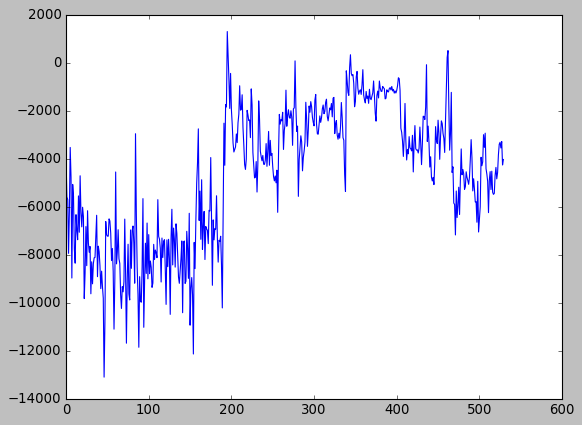

In [146]:
scaler = StandardScaler()

train_X, train_y, test_X, test_y, val_X, val_y = split_normalization_for_VIF_RFE_PCA(combination_df)



rfe = RFE(LinearRegression(),n_features_to_select=train_X.shape[1]-38)            
rfe = rfe.fit(train_X, train_y)

Train_X_std_rfe = train_X.loc[:,rfe.support_]
Test_X_std_rfe = test_X.loc[:,rfe.support_]
Val_X_std_rfe = val_X.loc[:,rfe.support_]



features_rfe.append(rfe.support_)

n_steps = 10
Train_X_std_rfe = split_sequences(Train_X_std_rfe, n_steps)
Test_X_std_rfe = split_sequences(Test_X_std_rfe, n_steps)
Val_X_std_rfe = split_sequences(Val_X_std_rfe, n_steps)


train_y_rfe = train_y[n_steps - 1: -1]
val_y_rfe = val_y[n_steps - 1: -1]
test_y_rfe = test_y[n_steps - 1: -1]

# design network
model = Sequential()
model.add(LSTM(256, input_shape=(Train_X_std_rfe.shape[1], Train_X_std_rfe.shape[2]), activation = 'elu',return_sequences=True))
model.add(LSTM(128, activation = 'elu',return_sequences=True))
model.add(LSTM(56, activation = 'elu'))
model.add(Dense(1))
model.compile(loss='mse', optimizer='rmsprop', metrics=["mean_absolute_error"])
# fit network

callback = tf.keras.callbacks.EarlyStopping(monitor='val_mean_absolute_error', patience=3)
model.fit(Train_X_std_rfe, train_y_rfe, batch_size=1, epochs=20, validation_data=(Val_X_std_rfe, val_y_rfe), callbacks = [callback])
# plot history

yhat_train = model.predict(Train_X_std_rfe)
yhat_test = model.predict(Test_X_std_rfe)


mean = scaler.mean_
mean = mean[len(mean) - 1]
scale = scaler.scale_
scale = scale[len(scale) - 1]

inv_yhat_train_RFE = yhat_train.reshape(yhat_train.shape[0])
inv_y_train_RFE = train_y_rfe.copy().values

for i in range(len(inv_yhat_train_RFE)):
    inv_yhat_train_RFE[i] = inv_yhat_train_RFE[i] * scale + mean
    inv_y_train_RFE[i] = inv_y_train_RFE [i] * scale + mean


inv_yhat_test_RFE = yhat_test.reshape(yhat_test.shape[0])
inv_y_test_RFE = test_y_rfe.copy().values
for i in range(len(inv_yhat_test_RFE)):
    inv_yhat_test_RFE[i] = inv_yhat_test_RFE[i] * scale + mean
    inv_y_test_RFE[i] = inv_y_test_RFE[i] * scale + mean
    
metrics(inv_y_test_RFE, inv_yhat_test_RFE)

PCA

In [ ]:
# split a multivariate sequence into samples
def split_sequences_PCA(df, n_steps):

    arrays = []
    for i in range(len(df.shape[0])):
        values = df[column].values
        a = values.reshape(len(values), 1)
        arrays.append(a)

    sequences = hstack((arrays))

    X, y = list(), list()
    for i in range(len(sequences)):

        end_ix = i + n_steps

        if end_ix > len(sequences)-1:
            break

        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return array(X)

In [ ]:
from sklearn.decomposition import PCA

scaler = StandardScaler()

train_X, train_y, test_X, test_y, val_X, val_y = split_normalization_for_VIF_RFE_PCA(df_candles_supervised)


Train_yhat_metrics_PCA={}
Train_yhat_metrics_PCA['RMSE'] = []
Train_yhat_metrics_PCA['MAPE'] = []
Train_yhat_metrics_PCA['SMAPE'] = []
Train_yhat_metrics_PCA['R2'] = []
Train_yhat_metrics_PCA['direction'] = []
Train_yhat_metrics_PCA['profit'] = []

Test_yhat_metrics_PCA={}
Test_yhat_metrics_PCA['RMSE'] = []
Test_yhat_metrics_PCA['MAPE'] = []
Test_yhat_metrics_PCA['SMAPE'] = []
Test_yhat_metrics_PCA['R2'] = []
Test_yhat_metrics_PCA['direction'] = []
Test_yhat_metrics_PCA['profit'] = []
 
m=train_X.shape[1]-1

features_pca = []

for i in range(m):
    
    pca = PCA(n_components=train_X.shape[1]-i)           
    
    Train_X_std_pca = pca.fit_transform(train_X)
    Val_X_std_pca = pca.fit_transform(val_X)
    Test_X_std_pca = pca.fit_transform(test_X)
    
    
    Train_X_std_pca = pd.DataFrame(Train_X_std_pca) 
    Test_X_std_pca = pd.DataFrame(Test_X_std_pca)
    Val_X_std_pca = pd.DataFrame(Val_X_std_pca)


    n_steps = 10
    Train_X_std_pca = split_sequences(Train_X_std_pca, n_steps)
    Test_X_std_pca = split_sequences(Test_X_std_pca, n_steps)
    Val_X_std_pca = split_sequences(Val_X_std_pca, n_steps)

    train_y_pca = train_y[n_steps - 1: -1]
    val_y_pca = val_y[n_steps - 1: -1]
    test_y_pca = test_y[n_steps - 1: -1]
    
    # design network
    model = Sequential()
    model.add(LSTM(256, input_shape=(Train_X_std_pca.shape[1], Train_X_std_pca.shape[2]), activation = 'elu',return_sequences=True))
    model.add(LSTM(128, activation = 'elu',return_sequences=True))
    model.add(LSTM(56, activation = 'elu'))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='rmsprop', metrics=["mean_absolute_error"])
    # fit network
    
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_mean_absolute_error', patience=3)
    model.fit(Train_X_std_pca, train_y_pca, batch_size=1, epochs=20, validation_data=(Val_X_std_pca, val_y_pca), callbacks = [callback])
    # plot history

    yhat_train = model.predict(Train_X_std_pca)
    yhat_test = model.predict(Test_X_std_pca)

    mean = scaler.mean_
    mean = mean[len(mean) - 1]
    scale = scaler.scale_
    scale = scale[len(scale) - 1]
    inv_yhat_train_PCA = yhat_train.reshape(yhat_train.shape[0])
    inv_y_train_PCA = train_y_rfe.copy().values
    for i in range(len(inv_yhat_train_PCA)):
        inv_yhat_train_PCA[i] = inv_yhat_train_PCA[i] * scale + mean
        inv_y_train_PCA[i] = inv_y_train_PCA[i] * scale + mean

    inv_yhat_test_PCA = yhat_test.reshape(yhat_test.shape[0])
    inv_y_test_PCA = test_y_pca.copy().values
    for i in range(len(inv_yhat_test_PCA)):
        inv_yhat_test_PCA[i] = inv_yhat_test_PCA[i] * scale + mean
        inv_y_test_PCA[i] = inv_y_test_PCA[i] * scale + mean

    Train_yhat_metrics_PCA['RMSE'].append(np.sqrt(mean_squared_error(inv_y_train_PCA, inv_yhat_train_PCA)))
    Train_yhat_metrics_PCA['MAPE'].append(round((abs(inv_y_train_PCA-inv_yhat_train_PCA)/inv_y_train_PCA).mean(),4))
    Train_yhat_metrics_PCA['SMAPE'].append(round(np.sqrt(smape(inv_y_train_PCA, inv_yhat_train_PCA)),20))
    Train_yhat_metrics_PCA['R2'].append(round(r2_score(inv_y_train_PCA, inv_yhat_train_PCA),20))
    Train_yhat_metrics_PCA['direction'].append(round(direction(inv_y_train_PCA, inv_yhat_train_PCA),4))
    Train_yhat_metrics_PCA['profit'].append(round(count_money(inv_y_train_PCA, inv_yhat_train_PCA), 20))

    Test_yhat_metrics_PCA['RMSE'].append(np.sqrt(mean_squared_error(inv_y_test_PCA, inv_yhat_test_PCA)))
    Test_yhat_metrics_PCA['MAPE'].append(round((abs(inv_y_test_PCA-inv_yhat_test_PCA)/inv_y_test_PCA).mean(),4))
    Test_yhat_metrics_PCA['SMAPE'].append(round(np.sqrt(smape(inv_y_test_PCA, inv_yhat_test_PCA)),20))
    Test_yhat_metrics_PCA['R2'].append(round(r2_score(inv_y_test_PCA, inv_yhat_test_PCA),20))
    Test_yhat_metrics_PCA['direction'].append(round(direction(inv_y_test_PCA, inv_yhat_test_PCA),4))
    Test_yhat_metrics_PCA['profit'].append(round(count_money(inv_y_test_PCA, inv_yhat_test_PCA), 20))

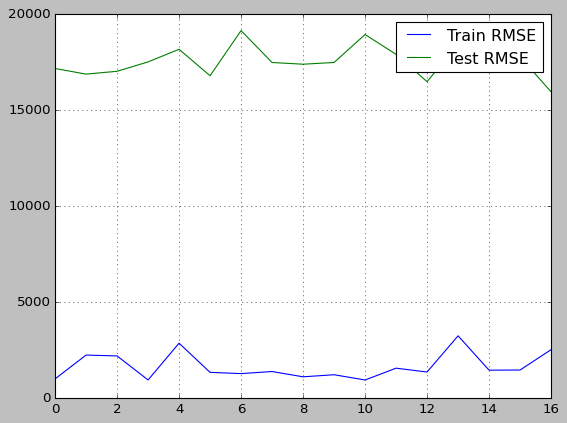

In [ ]:
plt.plot(Train_yhat_metrics_PCA['RMSE'], label='Train RMSE')
plt.plot(Test_yhat_metrics_PCA['RMSE'], label='Test RMSE')
plt.legend()
plt.grid()
plt.show()

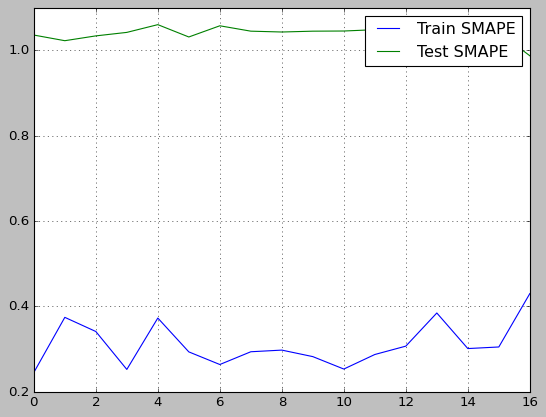

In [ ]:
plt.plot(Train_yhat_metrics_PCA['SMAPE'], label='Train SMAPE')
plt.plot(Test_yhat_metrics_PCA['SMAPE'], label='Test SMAPE')
plt.legend()
plt.grid()
plt.show()

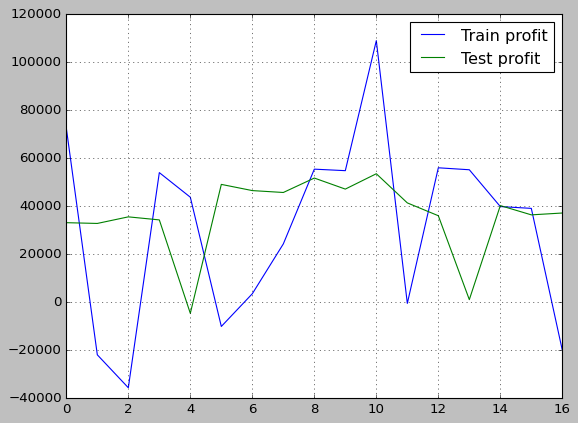

In [ ]:
plt.plot(Train_yhat_metrics_PCA['profit'], label='Train profit')
plt.plot(Test_yhat_metrics_PCA['profit'], label='Test profit')
plt.legend()
plt.grid()
plt.show()

# Quantity of candles Selection

In [167]:
For_Comparing_candles = pd.DataFrame(np.zeros([3,5]), columns=['R2','SMAPE','SE','Среднее угадывание направления','Прибыль'])

def Evaluate_candles(n, real,forecast):
   
    For_Comparing_candles.loc[n,'R2']  = round(r2_score(real,forecast),20)
    For_Comparing_candles.loc[n,'SMAPE']   = round(np.sqrt(smape(real, forecast)),20)
    For_Comparing_candles.loc[n,'SE'] = round(((real-forecast)**2).mean()**0.5,4)
    For_Comparing_candles.loc[n,'Среднее угадывание направления']  = round(direction(real, forecast),20)
    For_Comparing_candles.loc[n,'Прибыль']= round(count_money(real, forecast),20)

In [147]:
train_X.loc[:, rfe.support_]

,close,close_diff,zero_balance_addresses_all_time,unique_addresses_all_time
date,,,,
2018-06-16,-0.459225,0.081635,-1.586479,-1.574404
2018-06-17,-0.463627,-0.141517,-1.584808,-1.572634
2018-06-18,-0.438662,0.303229,-1.582348,-1.570197
2018-06-19,-0.436092,-0.035935,-1.579496,-1.567834
2018-06-20,-0.434151,-0.045452,-1.577022,-1.565365
...,...,...,...,...
2021-03-14,4.639459,-3.282778,1.883284,1.895590
2021-03-15,4.315654,-4.978716,1.887558,1.900071
2021-03-16,4.438032,1.778500,1.891892,1.904899


In [156]:
df = combination_df[['close','close_diff','zero_balance_addresses_all_time','unique_addresses_all_time','close_next']]
df

,close,close_diff,zero_balance_addresses_all_time,unique_addresses_all_time,close_next
date,,,,,
2018-06-16,6503.10,106.39,3.860796e+08,4.087123e+08,6457.78
2018-06-17,6457.78,-45.32,3.862683e+08,4.089194e+08,6714.82
2018-06-18,6714.82,257.04,3.865462e+08,4.092045e+08,6741.28
2018-06-19,6741.28,26.46,3.868683e+08,4.094810e+08,6761.27
2018-06-20,6761.27,19.99,3.871478e+08,4.097698e+08,6720.64
...,...,...,...,...,...
2023-05-15,27175.06,242.97,1.103570e+09,1.149887e+09,27036.63
2023-05-16,27036.63,-138.43,1.103901e+09,1.150278e+09,27404.35
2023-05-17,27404.35,367.72,1.104249e+09,1.150678e+09,26821.85


In [157]:
def build_model(hyperparams):
    model = Sequential()
    activation_choice = hyperparams.Choice('activation', values=['relu', 'elu', 'selu'])
    model.add(LSTM(units=hyperparams.Int('units_input',    # Полносвязный слой с разным количеством нейронов
                                   min_value=256,    # минимальное количество нейронов - 128
                                   max_value=512,   # максимальное количество - 1024
                                   step=8),
                           input_shape=(train_X.shape[1], train_X.shape[2]),
                    activation=activation_choice, return_sequences=True))
    BatchNormalization(),
    for i in range(hyperparams.Int('num_layers', min_value=0, max_value=5)):
        model.add(LSTM(units=hyperparams.Int('units_hidden',     
                                       min_value=128,   
                                       max_value=256,   
                                       step=8),
                          activation=activation_choice, return_sequences=True))
    
    model.add(LSTM(units=hyperparams.Int('units_output',    # Полносвязный слой с разным количеством нейронов
                                   min_value=56,   
                                   max_value=128,   
                                   step=8),
                    activation=activation_choice))
    model.add(Dense(1))

    optim=hyperparams.Choice("optimizer",["sgd","rmsprop","adam"])
    model.compile(optim, loss="mean_squared_error", metrics=["mean_absolute_error"])

    return model

In [158]:
def split_and_normalization(dataset):
    split = 0.8
    i_split = int(len(dataset) * split)
    train = dataset[:i_split]
    test = dataset[i_split:]
    i_split_val = int(len(train) * split)
    val = train[i_split_val:]
    train = train[:i_split_val]

    features = dataset.columns.values

    train_norm = train.values
    train_norm = scaler.fit_transform(train_norm)
    train_norm = pd.DataFrame(train_norm, columns=features)
    
    # test

    test_norm = test.values
    test_norm = scaler.transform(test_norm)
    test_norm = pd.DataFrame(test_norm, columns=features)
    
    
    # val
    val_norm = val.values
    val_norm = scaler.transform(val_norm)
    val_norm = pd.DataFrame(val_norm, columns=features)



    train_X = train_norm.drop(['close_next'],axis=1)
    # train_X.index = train_X['date']
    # train_X = train_X.drop(['date'],axis=1)
    train_y = train_norm['close_next']
    
    test_X = test_norm.drop(['close_next'],axis=1)
    # test_X.index = test_X['date']
    # test_X = test_X.drop(['date'],axis=1)
    test_y = test_norm['close_next']


    val_X = val_norm.drop(['close_next'],axis=1)
    # val_X.index = val_X['date']
    # val_X = val_X.drop(['date'],axis=1)
    val_y = val_norm['close_next']

    return train_X, train_y, test_X, test_y, val_X, val_y

Выберем оптимальное количество свечей в последовательности

3 свечи

Trial 10 Complete [00h 02m 49s]
val_mean_absolute_error: 0.11357968300580978

Best val_mean_absolute_error So Far: 0.10870956629514694
Total elapsed time: 00h 57m 11s
INFO:tensorflow:Oracle triggered exit
12/12 [==============================] - 3s 52ms/step
Тест на стационарность:
	T-статистика = -0.504
	P-значение = 0.891
Критические значения :
	1%: -3.4497880749874628 - Данные не стационарны с вероятностью 99% процентов
	5%: -2.870103829170425 - Данные не стационарны с вероятностью 95% процентов
	10%: -2.571332495975496 - Данные не стационарны с вероятностью 90% процентов
MAD: 727.1769
MSE: 898082.1807
MAPE: 0.0332
MPE: -0.0015
Стандартная ошибка: 947.672
Среднее угадывание направления:  0.5449438202247191
R2: 0.9468863862888068
SMAPE: 0.18187147431578812
Прибыль, при условии закрытия сделки по каждой свечи: 14163.009999999973
Прибыль, при условии закрытия сделки по каждой свечи (способ 2): -20246.987109375015


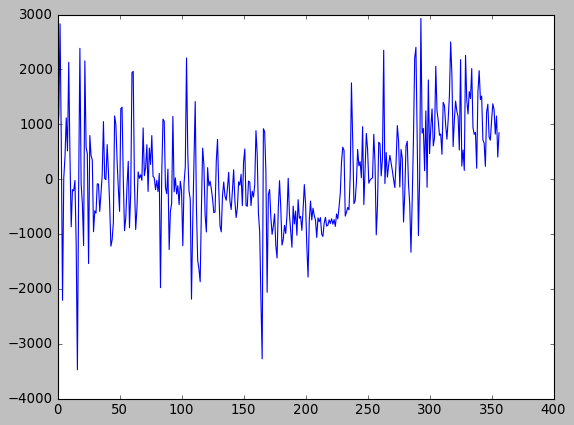

In [159]:
best_models_candle_3 = []

scaler = StandardScaler()

train_X, train_y, test_X, test_y, val_X, val_y = split_and_normalization(df)

n_steps = 3
train_X = split_sequences(train_X, n_steps)
test_X = split_sequences(test_X, n_steps)
val_X = split_sequences(val_X, n_steps)


train_y = train_y[n_steps - 1: -1]
val_y = val_y[n_steps - 1: -1]
test_y = test_y[n_steps - 1: -1]


from keras_tuner import RandomSearch
tuner1 =  RandomSearch(hypermodel=build_model,
                      objective="val_mean_absolute_error",
#                       objective=keras_tuner.Objective(name="val_mean_absolute_error",direction="min"),
                      max_trials=10,
                      #seed=123,
                      project_name="BTC1DLSTM-3",
                      overwrite=True
                    )
callback = tf.keras.callbacks.EarlyStopping(monitor='val_mean_absolute_error', patience=3, restore_best_weights=True)
# reduce_lr = ReduceLROnPlateau(monitor='val_mean_absolute_error', factor=0.2, patience=3, min_lr=0.000001, verbose=1)
tuner1.search(train_X, train_y, batch_size=1, epochs=20, validation_data=(val_X, val_y), callbacks = [callback])

best_model_ = tuner1.get_best_models()[0]
best_models_candle_3.append(best_model_)

yhat = best_model_.predict(test_X)

mean = scaler.mean_
mean = mean[len(mean) - 1]
scale = scaler.scale_
scale = scale[len(scale) - 1]
inv_yhat_OHLCV_3 = yhat.reshape(yhat.shape[0])
inv_y_OHLCV_3 = test_y.values
for i in range(len(inv_yhat_OHLCV_3)):
    inv_yhat_OHLCV_3[i] = inv_yhat_OHLCV_3[i] * scale + mean
    inv_y_OHLCV_3[i] = inv_y_OHLCV_3[i] * scale + mean

metrics(inv_y_OHLCV_3, inv_yhat_OHLCV_3)

In [169]:
Evaluate_candles(0, inv_y_OHLCV_3, inv_yhat_OHLCV_3)

5 свечей

Trial 10 Complete [00h 04m 53s]
val_mean_absolute_error: 0.16623690724372864

Best val_mean_absolute_error So Far: 0.09720686823129654
Total elapsed time: 01h 35m 30s
INFO:tensorflow:Oracle triggered exit
12/12 [==============================] - 2s 55ms/step
Тест на стационарность:
	T-статистика = -2.330
	P-значение = 0.162
Критические значения :
	1%: -3.449559661646851 - Данные не стационарны с вероятностью 99% процентов
	5%: -2.8700035112469626 - Данные не стационарны с вероятностью 95% процентов
	10%: -2.5712790073013796 - Данные не стационарны с вероятностью 90% процентов
MAD: 1989.7773
MSE: 5175490.29
MAPE: 0.1
MPE: -0.098
Стандартная ошибка: 2274.9704
Среднее угадывание направления:  0.4604519774011299
R2: 0.6905060546391577
SMAPE: 0.3054669254708469
Прибыль, при условии закрытия сделки по каждой свечи: 4280.949999999993
Прибыль, при условии закрытия сделки по каждой свечи (способ 2): -4996.087890625


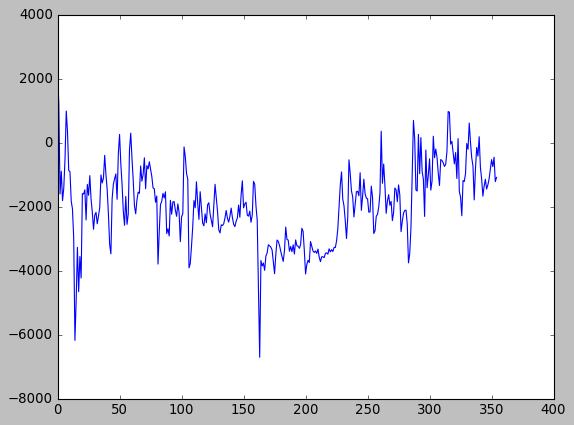

In [161]:
best_models_candle_5 = []

scaler = StandardScaler()

train_X, train_y, test_X, test_y, val_X, val_y = split_and_normalization(df)

n_steps = 5
train_X = split_sequences(train_X, n_steps)
test_X = split_sequences(test_X, n_steps)
val_X = split_sequences(val_X, n_steps)


train_y = train_y[n_steps - 1: -1]
val_y = val_y[n_steps - 1: -1]
test_y = test_y[n_steps - 1: -1]


from keras_tuner import RandomSearch
tuner1 =  RandomSearch(hypermodel=build_model,
                      objective="val_mean_absolute_error",
#                       objective=keras_tuner.Objective(name="val_mean_absolute_error",direction="min"),
                      max_trials=10,
                      #seed=123,
                      project_name="BTC1DLSTM-5",
                      overwrite=True
                    )
callback = tf.keras.callbacks.EarlyStopping(monitor='val_mean_absolute_error', patience=3, restore_best_weights=True)
# reduce_lr = ReduceLROnPlateau(monitor='val_mean_absolute_error', factor=0.2, patience=3, min_lr=0.000001, verbose=1)
tuner1.search(train_X, train_y, batch_size=1, epochs=20, validation_data=(val_X, val_y), callbacks = [callback])

best_model_ = tuner1.get_best_models()[0]
best_models_candle_5.append(best_model_)

yhat = best_model_.predict(test_X)

mean = scaler.mean_
mean = mean[len(mean) - 1]
scale = scaler.scale_
scale = scale[len(scale) - 1]
inv_yhat_OHLCV_5 = yhat.reshape(yhat.shape[0])
inv_y_OHLCV_5= test_y.values
for i in range(len(inv_yhat_OHLCV_5)):
    inv_yhat_OHLCV_5[i] = inv_yhat_OHLCV_5[i] * scale + mean
    inv_y_OHLCV_5[i] = inv_y_OHLCV_5[i] * scale + mean

metrics(inv_y_OHLCV_5, inv_yhat_OHLCV_5)

In [170]:
Evaluate_candles(1, inv_y_OHLCV_5, inv_yhat_OHLCV_5)

10 свечей

Trial 20 Complete [00h 24m 11s]
val_mean_absolute_error: 0.1599351316690445

Best val_mean_absolute_error So Far: 0.08539524674415588
Total elapsed time: 06h 58m 46s
INFO:tensorflow:Oracle triggered exit
11/11 [==============================] - 5s 116ms/step
Тест на стационарность:
	T-статистика = -8.224
	P-значение = 0.000
Критические значения :
	1%: -3.4492815848836296 - Данные  стационарны с вероятностью 99% процентов
	5%: -2.8698813715275406 - Данные  стационарны с вероятностью 95% процентов
	10%: -2.5712138845950587 - Данные  стационарны с вероятностью 90% процентов
MAD: 1033.5609
MSE: 1566842.2578
MAPE: 0.0465
MPE: -0.0386
Стандартная ошибка: 1251.7357
Среднее угадывание направления:  0.44126074498567336
R2: 0.9014201415156621
SMAPE: 0.21273555902820124
Прибыль, при условии закрытия сделки по каждой свечи: -1757.859999999997
Прибыль, при условии закрытия сделки по каждой свечи (способ 2): -18228.41679687499


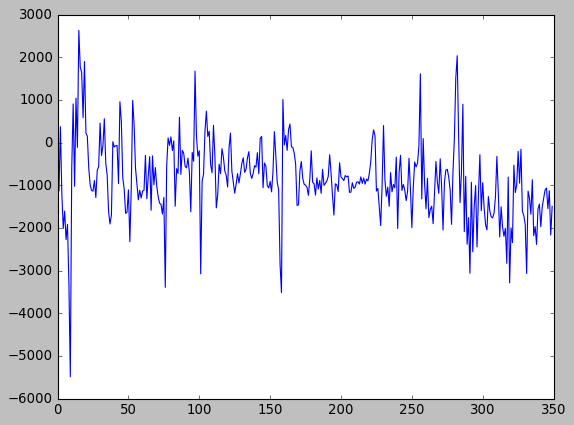

In [163]:
best_models_candle_10 = []

scaler = StandardScaler()

train_X, train_y, test_X, test_y, val_X, val_y = split_and_normalization(df)

n_steps = 10
train_X = split_sequences(train_X, n_steps)
test_X = split_sequences(test_X, n_steps)
val_X = split_sequences(val_X, n_steps)


train_y = train_y[n_steps - 1: -1]
val_y = val_y[n_steps - 1: -1]
test_y = test_y[n_steps - 1: -1]


from keras_tuner import RandomSearch
tuner1 =  RandomSearch(hypermodel=build_model,
                      objective="val_mean_absolute_error",
#                       objective=keras_tuner.Objective(name="val_mean_absolute_error",direction="min"),
                      max_trials=10,
                      #seed=123,
                      project_name="BTC1DLSTM-10",
                      overwrite=True
                    )
callback = tf.keras.callbacks.EarlyStopping(monitor='val_mean_absolute_error', patience=3, restore_best_weights=True)
# reduce_lr = ReduceLROnPlateau(monitor='val_mean_absolute_error', factor=0.2, patience=3, min_lr=0.000001, verbose=1)
tuner1.search(train_X, train_y, batch_size=1, epochs=20, validation_data=(val_X, val_y), callbacks = [callback])

best_model_ = tuner1.get_best_models()[0]
best_models_candle_10.append(best_model_)

yhat = best_model_.predict(test_X)

mean = scaler.mean_
mean = mean[len(mean) - 1]
scale = scaler.scale_
scale = scale[len(scale) - 1]
inv_yhat_OHLCV_10 = yhat.reshape(yhat.shape[0])
inv_y_OHLCV_10= test_y.values
for i in range(len(inv_yhat_OHLCV_10)):
    inv_yhat_OHLCV_10[i] = inv_yhat_OHLCV_10[i] * scale + mean
    inv_y_OHLCV_10[i] = inv_y_OHLCV_10[i] * scale + mean

metrics(inv_y_OHLCV_10, inv_yhat_OHLCV_10)

In [171]:
Evaluate_candles(2, inv_y_OHLCV_10, inv_yhat_OHLCV_10)

20 свечей

In [ ]:
best_models_candle_20 = []

scaler = StandardScaler()

train_X, train_y, test_X, test_y, val_X, val_y = split_and_normalization(df)

n_steps = 20
train_X = split_sequences(train_X, n_steps)
test_X = split_sequences(test_X, n_steps)
val_X = split_sequences(val_X, n_steps)


train_y = train_y[n_steps - 1: -1]
val_y = val_y[n_steps - 1: -1]
test_y = test_y[n_steps - 1: -1]


from keras_tuner import RandomSearch
tuner1 =  RandomSearch(hypermodel=build_model,
                      objective="val_mean_absolute_error",
#                       objective=keras_tuner.Objective(name="val_mean_absolute_error",direction="min"),
                      max_trials=10,
                      #seed=123,
                      project_name="BTC1DLSTM-20",
                      overwrite=True
                    )
callback = tf.keras.callbacks.EarlyStopping(monitor='val_mean_absolute_error', patience=3, restore_best_weights=True)
# reduce_lr = ReduceLROnPlateau(monitor='val_mean_absolute_error', factor=0.2, patience=3, min_lr=0.000001, verbose=1)
tuner1.search(train_X, train_y, batch_size=1, epochs=20, validation_data=(val_X, val_y), callbacks = [callback])

best_model_ = tuner1.get_best_models()[0]
best_models_candle_20.append(best_model_)

yhat = best_model_.predict(test_X)

mean = scaler.mean_
mean = mean[len(mean) - 1]
scale = scaler.scale_
scale = scale[len(scale) - 1]
inv_yhat_OHLCV_20 = yhat.reshape(yhat.shape[0])
inv_y_OHLCV_20= test_y.values
for i in range(len(inv_yhat_OHLCV_20)):
    inv_yhat_OHLCV_20[i] = inv_yhat_OHLCV_20[i] * scale + mean
    inv_y_OHLCV_20[i] = inv_y_OHLCV_20[i] * scale + mean

metrics(inv_y_OHLCV_20, inv_yhat_OHLCV_20)

In [ ]:
Evaluate_candles(3, inv_y_OHLCV_20, inv_yhat_OHLCV_20)

In [172]:
Table_of_Comapring_candles = For_Comparing_candles.copy()
Table_of_Comapring_candles.index = ['3','5','10']
Table_of_Comapring_candles

,R2,SMAPE,SE,Среднее угадывание направления,Прибыль
3,0.946886,0.181871,947.6720,0.544944,14163.01
5,0.690506,0.305467,2274.9704,0.460452,4280.95
10,0.901420,0.212736,1251.7357,0.441261,-1757.86


Лучшим результатом оказались последовательности длиной 3

# NN selection

Выбор наилучшего архитектуры

In [175]:
For_Comparing_NN = pd.DataFrame(np.zeros([5,5]), columns=['R2','SMAPE','SE','Среднее угадывание направления','Прибыль'])

def Evaluate_NN(n, real,forecast):
   
    For_Comparing_NN.loc[n,'R2']  = round(r2_score(real,forecast),20)
    For_Comparing_NN.loc[n,'SMAPE']   = round(np.sqrt(smape(real, forecast)),20)
    For_Comparing_NN.loc[n,'SE'] = round(((real-forecast)**2).mean()**0.5,4)
    For_Comparing_NN.loc[n,'Среднее угадывание направления']  = round(direction(real, forecast),20)
    For_Comparing_NN.loc[n,'Прибыль']= round(count_money(real, forecast),20)



LSTM

Trial 10 Complete [00h 24m 02s]
val_mean_absolute_error: 1.8706003427505493

Best val_mean_absolute_error So Far: 0.08373016864061356
Total elapsed time: 01h 48m 05s
INFO:tensorflow:Oracle triggered exit
12/12 [==============================] - 3s 41ms/step
Тест на стационарность:
	T-статистика = -6.712
	P-значение = 0.000
Критические значения :
	1%: -3.4490114443793214 - Данные  стационарны с вероятностью 99% процентов
	5%: -2.8697627072503757 - Данные  стационарны с вероятностью 95% процентов
	10%: -2.5711506161673716 - Данные  стационарны с вероятностью 90% процентов
MAD: 758.6412
MSE: 941433.5258
MAPE: 0.034
MPE: 0.0233
Стандартная ошибка: 970.275
Среднее угадывание направления:  0.5308988764044944
R2: 0.9443225378461031
SMAPE: 0.18595504291569978
Прибыль, при условии закрытия сделки по каждой свечи: -15501.37000000003
Прибыль, при условии закрытия сделки по каждой свечи (способ 2): -40077.89703125


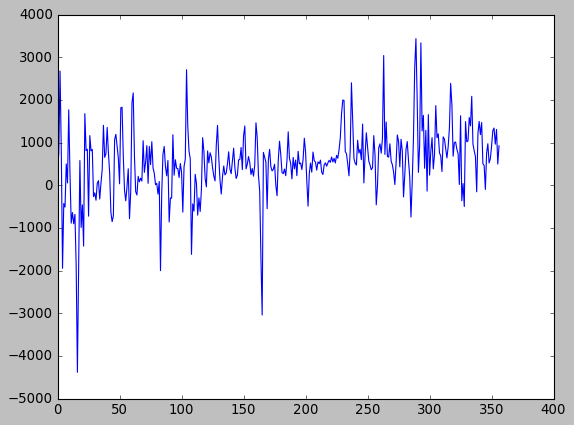

In [176]:
def build_model_LSTM(hyperparams):
    model = Sequential()
    activation_choice = hyperparams.Choice('activation', values=['relu', 'elu', 'selu'])
    model.add(LSTM(units=hyperparams.Int('units_input',    # Полносвязный слой с разным количеством нейронов
                                   min_value=256,    # минимальное количество нейронов - 128
                                   max_value=512,   # максимальное количество - 1024
                                   step=8),
                           input_shape=(train_X.shape[1], train_X.shape[2]),
                    activation=activation_choice, return_sequences=True))
    for i in range(hyperparams.Int('num_layers', min_value=0, max_value=5)):
        model.add(LSTM(units=hyperparams.Int('units_hidden',     
                                       min_value=128,   
                                       max_value=256,   
                                       step=8),
                          activation=activation_choice, return_sequences=True))
    
    model.add(LSTM(units=hyperparams.Int('units_output',    # Полносвязный слой с разным количеством нейронов
                                   min_value=56,   
                                   max_value=128,   
                                   step=8),
                    activation=activation_choice))
    model.add(Dense(1))

    optim=hyperparams.Choice("optimizer",["sgd","rmsprop","adam"])
    model.compile(optim, loss="mean_squared_error", metrics=["mean_absolute_error"])

    return model


best_models_LSTM = []

scaler = StandardScaler()

train_X, train_y, test_X, test_y, val_X, val_y = split_and_normalization(df)

n_steps = 3
train_X = split_sequences(train_X, n_steps)
test_X = split_sequences(test_X, n_steps)
val_X = split_sequences(val_X, n_steps)


train_y = train_y[n_steps - 1: -1]
val_y = val_y[n_steps - 1: -1]
test_y = test_y[n_steps - 1: -1]


from keras_tuner import RandomSearch
tuner1 =  RandomSearch(hypermodel=build_model_LSTM,
                      objective="val_mean_absolute_error",
#                       objective=keras_tuner.Objective(name="val_mean_absolute_error",direction="min"),
                      max_trials=10,
                      #seed=123,
                      project_name="BTC-LSTM-1D",
                      overwrite=True
                    )
callback = tf.keras.callbacks.EarlyStopping(monitor='val_mean_absolute_error', patience=3, restore_best_weights=True)
# reduce_lr = ReduceLROnPlateau(monitor='val_mean_absolute_error', factor=0.2, patience=3, min_lr=0.000001, verbose=1)
tuner1.search(train_X, train_y, batch_size=1, epochs=20, validation_data=(val_X, val_y), callbacks = [callback])

best_model_ = tuner1.get_best_models()[0]
best_models_LSTM.append(best_model_)

yhat = best_model_.predict(test_X)

mean = scaler.mean_
mean = mean[len(mean) - 1]
scale = scaler.scale_
scale = scale[len(scale) - 1]
inv_yhat_OHLCV_LSTM = yhat.reshape(yhat.shape[0])
inv_y_OHLCV_LSTM= test_y.values
for i in range(len(inv_yhat_OHLCV_LSTM)):
    inv_yhat_OHLCV_LSTM[i] = inv_yhat_OHLCV_LSTM[i] * scale + mean
    inv_y_OHLCV_LSTM[i] = inv_y_OHLCV_LSTM[i] * scale + mean

metrics(inv_y_OHLCV_LSTM, inv_yhat_OHLCV_LSTM)

In [177]:
best_model_.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 3, 352)            502656    
                                                                 
 lstm_1 (LSTM)               (None, 80)                138560    
                                                                 
 dense (Dense)               (None, 1)                 81        
                                                                 
Total params: 641,297
Trainable params: 641,297
Non-trainable params: 0
_________________________________________________________________


In [178]:
Evaluate_NN(0, inv_y_OHLCV_LSTM, inv_yhat_OHLCV_LSTM)

GRU

Trial 10 Complete [00h 02m 07s]
val_mean_absolute_error: 0.18537254631519318

Best val_mean_absolute_error So Far: 0.09323418885469437
Total elapsed time: 00h 24m 47s
INFO:tensorflow:Oracle triggered exit
12/12 [==============================] - 7s 84ms/step
Тест на стационарность:
	T-статистика = -6.545
	P-значение = 0.000
Критические значения :
	1%: -3.4490648539347544 - Данные  стационарны с вероятностью 99% процентов
	5%: -2.8697861692116478 - Данные  стационарны с вероятностью 95% процентов
	10%: -2.5711631253228306 - Данные  стационарны с вероятностью 90% процентов
MAD: 637.7782
MSE: 773900.7006
MAPE: 0.0294
MPE: -0.0196
Стандартная ошибка: 879.7163
Среднее угадывание направления:  0.4410112359550562
R2: 0.9542306219346786
SMAPE: 0.16969699256073023
Прибыль, при условии закрытия сделки по каждой свечи: -10368.349999999984
Прибыль, при условии закрытия сделки по каждой свечи (способ 2): -42610.00234374998


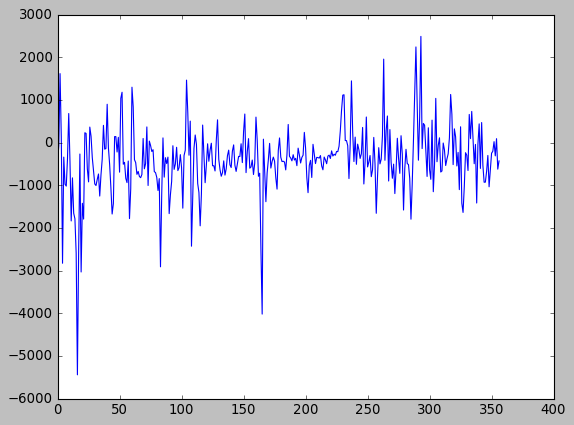

In [179]:
def build_model_GRU(hyperparams):
    model = Sequential()
    activation_choice = hyperparams.Choice('activation', values=['relu', 'elu', 'selu'])
    model.add(GRU(units=hyperparams.Int('units_input',    # Полносвязный слой с разным количеством нейронов
                                   min_value=256,    # минимальное количество нейронов - 128
                                   max_value=512,   # максимальное количество - 1024
                                   step=8),
                           input_shape=(train_X.shape[1], train_X.shape[2]),
                    activation=activation_choice, return_sequences=True))
    for i in range(hyperparams.Int('num_layers', min_value=0, max_value=5)):
        model.add(GRU(units=hyperparams.Int('units_hidden',     
                                       min_value=128,   
                                       max_value=256,   
                                       step=8),
                          activation=activation_choice, return_sequences=True))
    
    model.add(GRU(units=hyperparams.Int('units_output',    # Полносвязный слой с разным количеством нейронов
                                   min_value=56,   
                                   max_value=128,   
                                   step=8),
                    activation=activation_choice))
    model.add(Dense(1))

    optim=hyperparams.Choice("optimizer",["sgd","rmsprop","adam"])
    model.compile(optim, loss="mean_squared_error", metrics=["mean_absolute_error"])

    return model

best_models_GRU = []

scaler = StandardScaler()

train_X, train_y, test_X, test_y, val_X, val_y = split_and_normalization(df)

n_steps = 3
train_X = split_sequences(train_X, n_steps)
test_X = split_sequences(test_X, n_steps)
val_X = split_sequences(val_X, n_steps)


train_y = train_y[n_steps - 1: -1]
val_y = val_y[n_steps - 1: -1]
test_y = test_y[n_steps - 1: -1]


from keras_tuner import RandomSearch
tuner1 =  RandomSearch(hypermodel=build_model_GRU,
                      objective="val_mean_absolute_error",
#                       objective=keras_tuner.Objective(name="val_mean_absolute_error",direction="min"),
                      max_trials=10,
                      #seed=123,
                      project_name="BTC-GRU-1D",
                      overwrite=True
                    )
callback = tf.keras.callbacks.EarlyStopping(monitor='val_mean_absolute_error', patience=3, restore_best_weights=True)
# reduce_lr = ReduceLROnPlateau(monitor='val_mean_absolute_error', factor=0.2, patience=3, min_lr=0.000001, verbose=1)
tuner1.search(train_X, train_y, batch_size=72, epochs=20, validation_data=(val_X, val_y), callbacks = [callback])

best_model_ = tuner1.get_best_models()[0]
best_models_GRU.append(best_model_)

yhat = best_model_.predict(test_X)

mean = scaler.mean_
mean = mean[len(mean) - 1]
scale = scaler.scale_
scale = scale[len(scale) - 1]
inv_yhat_OHLCV_GRU = yhat.reshape(yhat.shape[0])
inv_y_OHLCV_GRU= test_y.values
for i in range(len(inv_yhat_OHLCV_GRU)):
    inv_yhat_OHLCV_GRU[i] = inv_yhat_OHLCV_GRU[i] * scale + mean
    inv_y_OHLCV_GRU[i] = inv_y_OHLCV_GRU[i] * scale + mean

metrics(inv_y_OHLCV_GRU, inv_yhat_OHLCV_GRU)

In [180]:
best_model_.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 3, 432)            567648    
                                                                 
 gru_1 (GRU)                 (None, 3, 208)            400608    
                                                                 
 gru_2 (GRU)                 (None, 3, 208)            260832    
                                                                 
 gru_3 (GRU)                 (None, 80)                69600     
                                                                 
 dense (Dense)               (None, 1)                 81        
                                                                 
Total params: 1,298,769
Trainable params: 1,298,769
Non-trainable params: 0
_________________________________________________________________


In [181]:
Evaluate_NN(1, inv_y_OHLCV_GRU, inv_yhat_OHLCV_GRU)

BiLSTM

Trial 10 Complete [00h 03m 19s]
val_mean_absolute_error: 0.14205193519592285

Best val_mean_absolute_error So Far: 0.08321423083543777
Total elapsed time: 00h 43m 24s
INFO:tensorflow:Oracle triggered exit
12/12 [==============================] - 31s 202ms/step
Тест на стационарность:
	T-статистика = -1.652
	P-значение = 0.456
Критические значения :
	1%: -3.4495033946549123 - Данные не стационарны с вероятностью 99% процентов
	5%: -2.8699787979596136 - Данные не стационарны с вероятностью 95% процентов
	10%: -2.5712658305164955 - Данные не стационарны с вероятностью 90% процентов
MAD: 1317.4018
MSE: 2311149.551
MAPE: 0.0583
MPE: 0.0525
Стандартная ошибка: 1520.2465
Среднее угадывание направления:  0.547752808988764
R2: 0.8633159557999797
SMAPE: 0.24538236490602694
Прибыль, при условии закрытия сделки по каждой свечи: -221.2700000000041
Прибыль, при условии закрытия сделки по каждой свечи (способ 2): -17346.620390624998


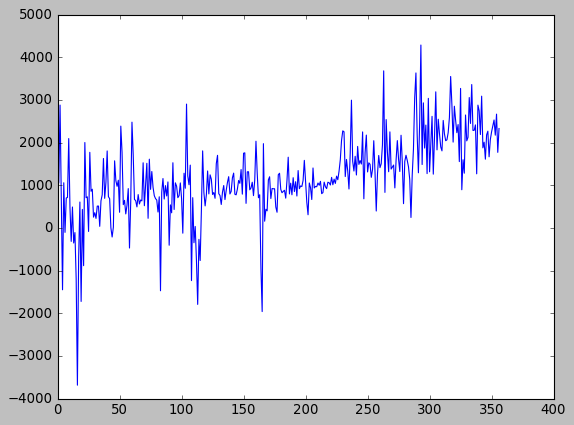

In [182]:
def build_model_BiLSTM(hyperparams):
    model = Sequential()
    activation_choice = hyperparams.Choice('activation', values=['relu', 'elu', 'selu'])
    model.add(Bidirectional(LSTM(units=hyperparams.Int('units_input',    # Полносвязный слой с разным количеством нейронов
                                   min_value=256,    # минимальное количество нейронов - 128
                                   max_value=512,   # максимальное количество - 1024
                                   step=8),
                           input_shape=(train_X.shape[1], train_X.shape[2]),
                    activation=activation_choice, return_sequences=True)))
    for i in range(hyperparams.Int('num_layers', min_value=0, max_value=5)):
        model.add(Bidirectional(LSTM(units=hyperparams.Int('units_hidden',     
                                       min_value=128,   
                                       max_value=256,   
                                       step=8),
                          activation=activation_choice, return_sequences=True)))
    
    model.add(Bidirectional(LSTM(units=hyperparams.Int('units_output',    # Полносвязный слой с разным количеством нейронов
                                   min_value=56,   
                                   max_value=128,   
                                   step=8),
                    activation=activation_choice)))
    model.add(Dense(1))

    optim=hyperparams.Choice("optimizer",["sgd","rmsprop","adam"])
    model.compile(optim, loss="mean_squared_error", metrics=["mean_absolute_error"])

    return model

best_models_BiLSTM = []

scaler = StandardScaler()

train_X, train_y, test_X, test_y, val_X, val_y = split_and_normalization(df)

n_steps = 3
train_X = split_sequences(train_X, n_steps)
test_X = split_sequences(test_X, n_steps)
val_X = split_sequences(val_X, n_steps)


train_y = train_y[n_steps - 1: -1]
val_y = val_y[n_steps - 1: -1]
test_y = test_y[n_steps - 1: -1]


from keras_tuner import RandomSearch
tuner1 =  RandomSearch(hypermodel=build_model_BiLSTM,
                      objective="val_mean_absolute_error",
#                       objective=keras_tuner.Objective(name="val_mean_absolute_error",direction="min"),
                      max_trials=10,
                      #seed=123,
                      project_name="BTC-BiLSTM-1D",
                      overwrite=True
                    )
callback = tf.keras.callbacks.EarlyStopping(monitor='val_mean_absolute_error', patience=3, restore_best_weights=True)
# reduce_lr = ReduceLROnPlateau(monitor='val_mean_absolute_error', factor=0.2, patience=3, min_lr=0.000001, verbose=1)
tuner1.search(train_X, train_y, batch_size=72, epochs=20, validation_data=(val_X, val_y), callbacks = [callback])

best_model_ = tuner1.get_best_models()[0]
best_models_BiLSTM.append(best_model_)

yhat = best_model_.predict(test_X)

mean = scaler.mean_
mean = mean[len(mean) - 1]
scale = scaler.scale_
scale = scale[len(scale) - 1]
inv_yhat_OHLCV_BiLSTM = yhat.reshape(yhat.shape[0])
inv_y_OHLCV_BiLSTM= test_y.values
for i in range(len(inv_yhat_OHLCV_BiLSTM)):
    inv_yhat_OHLCV_BiLSTM[i] = inv_yhat_OHLCV_BiLSTM[i] * scale + mean
    inv_y_OHLCV_BiLSTM[i] = inv_y_OHLCV_BiLSTM[i] * scale + mean

metrics(inv_y_OHLCV_BiLSTM, inv_yhat_OHLCV_BiLSTM)

In [183]:
best_model_.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 3, 672)           916608    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 3, 256)           820224    
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 3, 256)           394240    
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 3, 256)           394240    
 nal)                                                            
                                                                 
 bidirectional_4 (Bidirectio  (None, 176)              2

In [184]:
Evaluate_NN(2, inv_y_OHLCV_BiLSTM, inv_yhat_OHLCV_BiLSTM)

BiGRU

Trial 10 Complete [00h 29m 36s]
val_mean_absolute_error: 0.21171064674854279

Best val_mean_absolute_error So Far: 0.08963963389396667
Total elapsed time: 03h 26m 28s
INFO:tensorflow:Oracle triggered exit
12/12 [==============================] - 10s 148ms/step
Тест на стационарность:
	T-статистика = -4.398
	P-значение = 0.000
Критические значения :
	1%: -3.44911857009962 - Данные  стационарны с вероятностью 99% процентов
	5%: -2.8698097654570507 - Данные  стационарны с вероятностью 95% процентов
	10%: -2.5711757061225153 - Данные  стационарны с вероятностью 90% процентов
MAD: 2424.135
MSE: 6850244.3422
MAPE: 0.1187
MPE: -0.1182
Стандартная ошибка: 2617.2971
Среднее угадывание направления:  0.45224719101123595
R2: 0.5948686660988765
SMAPE: 0.3322429812886423
Прибыль, при условии закрытия сделки по каждой свечи: -2125.5699999999997
Прибыль, при условии закрытия сделки по каждой свечи (способ 2): -4837.720156249998


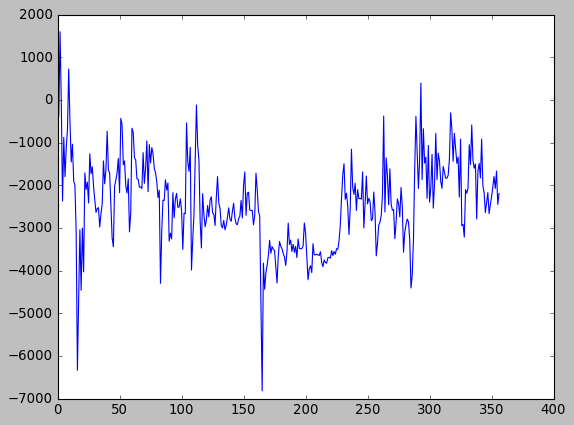

In [185]:
def build_model_BiGRU(hyperparams):
    model = Sequential()
    activation_choice = hyperparams.Choice('activation', values=['relu', 'elu', 'selu'])
    model.add(Bidirectional(GRU(units=hyperparams.Int('units_input',    # Полносвязный слой с разным количеством нейронов
                                   min_value=256,    # минимальное количество нейронов - 128
                                   max_value=512,   # максимальное количество - 1024
                                   step=8),
                           input_shape=(train_X.shape[1], train_X.shape[2]),
                    activation=activation_choice, return_sequences=True)))
    for i in range(hyperparams.Int('num_layers', min_value=0, max_value=5)):
        model.add(Bidirectional(GRU(units=hyperparams.Int('units_hidden',     
                                       min_value=128,   
                                       max_value=256,   
                                       step=8),
                          activation=activation_choice, return_sequences=True)))
    
    model.add(Bidirectional(GRU(units=hyperparams.Int('units_output',    # Полносвязный слой с разным количеством нейронов
                                   min_value=56,   
                                   max_value=128,   
                                   step=8),
                    activation=activation_choice)))
    model.add(Dense(1))

    optim=hyperparams.Choice("optimizer",["sgd","rmsprop","adam"])
    model.compile(optim, loss="mean_squared_error", metrics=["mean_absolute_error"])

    return model


best_models_BiGRU = []

scaler = StandardScaler()

train_X, train_y, test_X, test_y, val_X, val_y = split_and_normalization(df)

n_steps = 3
train_X = split_sequences(train_X, n_steps)
test_X = split_sequences(test_X, n_steps)
val_X = split_sequences(val_X, n_steps)


train_y = train_y[n_steps - 1: -1]
val_y = val_y[n_steps - 1: -1]
test_y = test_y[n_steps - 1: -1]


from keras_tuner import RandomSearch
tuner1 =  RandomSearch(hypermodel=build_model_BiGRU,
                      objective="val_mean_absolute_error",
#                       objective=keras_tuner.Objective(name="val_mean_absolute_error",direction="min"),
                      max_trials=10,
                      #seed=123,
                      project_name="BTC-BiGRU-1D",
                      overwrite=True
                    )
callback = tf.keras.callbacks.EarlyStopping(monitor='val_mean_absolute_error', patience=3, restore_best_weights=True)
# reduce_lr = ReduceLROnPlateau(monitor='val_mean_absolute_error', factor=0.2, patience=3, min_lr=0.000001, verbose=1)
tuner1.search(train_X, train_y, batch_size=1, epochs=20, validation_data=(val_X, val_y), callbacks = [callback])

best_model_ = tuner1.get_best_models()[0]
best_models_BiGRU.append(best_model_)

yhat = best_model_.predict(test_X)

mean = scaler.mean_
mean = mean[len(mean) - 1]
scale = scaler.scale_
scale = scale[len(scale) - 1]
inv_yhat_OHLCV_BiGRU = yhat.reshape(yhat.shape[0])
inv_y_OHLCV_BiGRU= test_y.values
for i in range(len(inv_yhat_OHLCV_BiGRU)):
    inv_yhat_OHLCV_BiGRU[i] = inv_yhat_OHLCV_BiGRU[i] * scale + mean
    inv_y_OHLCV_BiGRU[i] = inv_y_OHLCV_BiGRU[i] * scale + mean

metrics(inv_y_OHLCV_BiGRU, inv_yhat_OHLCV_BiGRU)

In [186]:
best_model_.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 3, 672)           689472    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 3, 416)           1100736   
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 3, 416)           781248    
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 160)              239040    
 nal)                                                            
                                                                 
 dense (Dense)               (None, 1)                 1

In [187]:
Evaluate_NN(3, inv_y_OHLCV_BiGRU, inv_yhat_OHLCV_BiGRU)

Conv-LSTM

Trial 9 Complete [00h 02m 12s]
val_mean_absolute_error: 0.0974026694893837

Best val_mean_absolute_error So Far: 0.08387542515993118
Total elapsed time: 00h 19m 57s
INFO:tensorflow:Oracle triggered exit
12/12 [==============================] - 2s 9ms/step
Тест на стационарность:
	T-статистика = -1.826
	P-значение = 0.368
Критические значения :
	1%: -3.4495033946549123 - Данные не стационарны с вероятностью 99% процентов
	5%: -2.8699787979596136 - Данные не стационарны с вероятностью 95% процентов
	10%: -2.5712658305164955 - Данные не стационарны с вероятностью 90% процентов
MAD: 846.8641
MSE: 1191590.4388
MAPE: 0.0365
MPE: 0.0271
Стандартная ошибка: 1091.5999
Среднее угадывание направления:  0.5561797752808989
R2: 0.9295279701231539
SMAPE: 0.1928662855217915
Прибыль, при условии закрытия сделки по каждой свечи: 5719.849999999989
Прибыль, при условии закрытия сделки по каждой свечи (способ 2): -23983.663476562502


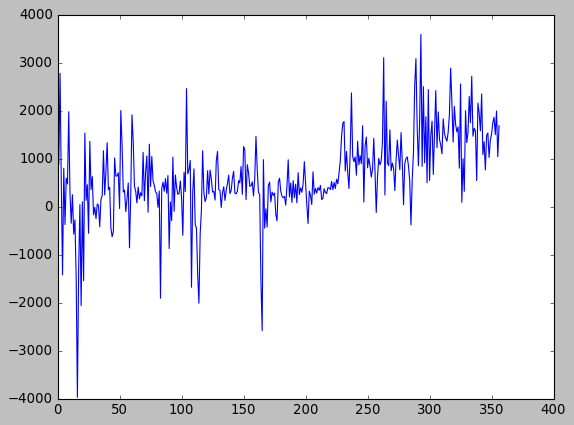

In [188]:
scaler = StandardScaler()

train_X, train_y, test_X, test_y, val_X, val_y = split_and_normalization(df)

n_steps = 3
train_X = split_sequences(train_X, n_steps)
test_X = split_sequences(test_X, n_steps)
val_X = split_sequences(val_X, n_steps)

train_X = train_X.reshape((train_X.shape[0], 1, 1, train_X.shape[1],train_X.shape[2]))
test_X = test_X.reshape((test_X.shape[0], 1, 1, test_X.shape[1],test_X.shape[2]))
val_X = val_X.reshape((val_X.shape[0], 1, 1, val_X.shape[1],val_X.shape[2]))

print(train_X.shape)

train_y = train_y[n_steps - 1: -1]
val_y = val_y[n_steps - 1: -1]
test_y = test_y[n_steps - 1: -1]



def build_model_ConvLSTM(hyperparams):
    model = Sequential()
    activation_choice = hyperparams.Choice('activation', values=['relu', 'elu', 'selu'])
    model.add(ConvLSTM2D(input_shape=(1, 1, train_X.shape[3], train_X.shape[4]),
                            activation=activation_choice, filters=32, padding='same', kernel_size=(1,5)))
    
    model.add(Flatten())
    model.add(Dense(1))

    optim=hyperparams.Choice("optimizer",["sgd","rmsprop","adam"])
    model.compile(optim, loss="mean_squared_error", metrics=["mean_absolute_error"])

    return model

from keras_tuner import RandomSearch
tuner1 =  RandomSearch(hypermodel=build_model_ConvLSTM,
                      objective="val_mean_absolute_error",
#                       objective=keras_tuner.Objective(name="val_mean_absolute_error",direction="min"),
                      max_trials=10,
                      #seed=123,
                      project_name="BTCCONVLSTM",
                      overwrite=True
                    )
callback = tf.keras.callbacks.EarlyStopping(monitor='val_mean_absolute_error', patience=3, restore_best_weights=True)
# reduce_lr = ReduceLROnPlateau(monitor='val_mean_absolute_error', factor=0.2, patience=3, min_lr=0.000001, verbose=1)
tuner1.search(train_X, train_y, batch_size=1, epochs=20, validation_data=(val_X, val_y), callbacks = [callback])

best_model_ = tuner1.get_best_models()[0]


yhat = best_model_.predict(test_X)

mean = scaler.mean_
mean = mean[len(mean) - 1]
scale = scaler.scale_
scale = scale[len(scale) - 1]
inv_yhat_OHLCV_ConvLSTM = yhat.reshape(yhat.shape[0])
inv_y_OHLCV_ConvLSTM= test_y.values
for i in range(len(inv_yhat_OHLCV_ConvLSTM)):
    inv_yhat_OHLCV_ConvLSTM[i] = inv_yhat_OHLCV_ConvLSTM[i] * scale + mean
    inv_y_OHLCV_ConvLSTM[i] = inv_y_OHLCV_ConvLSTM[i] * scale + mean

metrics(inv_y_OHLCV_ConvLSTM, inv_yhat_OHLCV_ConvLSTM)

In [189]:
best_model_.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 1, 3, 32)          23168     
                                                                 
 flatten (Flatten)           (None, 96)                0         
                                                                 
 dense (Dense)               (None, 1)                 97        
                                                                 
Total params: 23,265
Trainable params: 23,265
Non-trainable params: 0
_________________________________________________________________


In [190]:
Evaluate_NN(4, inv_y_OHLCV_ConvLSTM, inv_yhat_OHLCV_ConvLSTM)

In [191]:
Table_of_Comapring_NN = For_Comparing_NN.copy()
Table_of_Comapring_NN.index = ['LSTM','GRU','BiLSTM','BiGRU','CONV-LSTM']
Table_of_Comapring_NN

,R2,SMAPE,SE,Среднее угадывание направления,Прибыль
LSTM,0.944323,0.185955,970.2750,0.530899,-15501.37
GRU,0.954231,0.169697,879.7163,0.441011,-10368.35
BiLSTM,0.863316,0.245382,1520.2465,0.547753,-221.27
BiGRU,0.594869,0.332243,2617.2971,0.452247,-2125.57
CONV-LSTM,0.929528,0.192866,1091.5999,0.556180,5719.85


Лучше всего себя показали LSTM и CONV-LSTM сеть